# Jupyter Notebook for Running Experiments on Hyperspectral Autoencoder

Written by Arya C. Mugdha and Jesse W. Wilson (2023 - 2024)
[This notebook is still being modified]

Many features are experimental and not fully functional.

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
%matplotlib inline

# for reading and displaying images
from skimage import io
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Tanh, Hardtanh, LeakyReLU, ELU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as f
import torchvision.transforms as transforms
from torch.optim.swa_utils import AveragedModel, SWALR
from scipy.stats import mode
from scipy import stats, optimize
from scipy.interpolate import griddata, RBFInterpolator


In [2]:
data = os.uname()
username = os.getlogin()
global device
if data[1] == 'lambda-dual':
    device = 'cuda:1'
    print('The model will be trained on {}'.format(device))
    data_dir = '/home/'+username+'/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/home/'+username+'/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('Data will be loaded from "{}"'.format(data_dir))
    print('Data will be saved to "{}"'.format(save_dir))
elif data[1] == 'linuxg3' or data[1] == 'linuxg4':
    device = 'cuda:0'
    data_dir = '/top/projects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/top/projects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('The model will be trained on {}'.format(device))
    print('Data will be saved to "{}"'.format(save_dir))
    

The model will be trained on cuda:1
Data will be loaded from "/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/"
Data will be saved to "/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/"


# Load dataset

In [3]:
# loading dataset
filenames = os.listdir(data_dir)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    img_stack.append(img)

# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')

# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('Input dataset specs:')
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

# process the input image stack
img_stack = torch.tensor(img_stack)
img_stack = img_stack.to(device)

Input dataset specs:
img width = 681, img height = 406, img channels = 9


In [4]:
def load_batch_data(img_stack, batch_size, patch_size):
    batch_stack = []
    for i in range(0,batch_size):
        transform = transforms.RandomCrop((patch_size, patch_size))
        img_stack_p = torch.permute(img_stack, (0, 3, 1, 2))
        image_crop = transform(img_stack_p[random.randint(0,22),:,:,:])
#         print(image_crop.size)
        image_crop = torch.permute(image_crop, (1,2,0))
        batch_stack.append(image_crop)
    return batch_stack

def sort_tuple(data):
    data.sort(key = lambda x : x[0])
    return data

def orthogonalColorPalette( n ):
    # generates a list of n colors, with even hue angle spacing between
    h = np.linspace(0,1,n+1)[0:-1]  # evenly spaced hue angles
    s = np.ones_like(h)             # saturation = 1 
    v = s                           # value = 1
    hsv = np.stack((h,s,v)).T       # hue-sat-value vectors
    M = hsv_to_rgb(hsv)             # convert to RGB
    
    return M

    
def abundancemapToRGB( z ):
    # (JWW 20221208 jesse.wilson@colostate.edu)
    # inspired by Du, et al., "Color Display for Hyperspectral Imagery",
    #             IEEE Trans Geosci and Remote Sens,. v46 no6 (2008).
    
    # generate a color palatte M, one for each endmember,
    # where colors are spaced evely around the color wheel
    ny, nx, nch = z.shape
    M = orthogonalColorPalette(nch)
    
    # the RGB images is simply the tensor dot product between the 
    # abundance map and the color palette,
    # summing over the abundance map's channel axis and 
    # over the color palette's index axis
    rgb = np.tensordot(z,M,(2,0))
    
    return rgb
    
def plotEndmembers( t, w, ax=None ):
    nt, nch = w.shape
    M = orthogonalColorPalette(nch)
    
    if ax==None:
        ax=plt.axes()
    ax.set_facecolor('black')

    for i in range(nch):
        plt.plot(t,w[:,i],color=M[i,:])

# Define functions

In [5]:
class ResnetBlock(Module):
    def __init__(self, channels, kernel_size, stride, padding):
        super(ResnetBlock, self).__init__()
        self.conv = Sequential(
                        Conv2d(in_channels=channels, 
                          out_channels=channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, bias=False) )
        
    def forward(self, x):
        intermediate = self.conv(x)
        out = x + intermediate
        return out
        

class ScalableSat(Module):
    def __init__(self):
        super(ScalableSat, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([1.0,1.0,0.0]))
        self.tanh = Hardtanh()
        #self.tanh = Tanh()
        
    def forward(self,x):
        return self.a[1]*self.tanh(self.a[0]*x)+self.a[2]
    
class LeakyHardsigmoid(Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyHardsigmoid,self).__init__()
        self.ns = negative_slope
        
    def forward(self,x):
        return f.leaky_relu(-f.leaky_relu(-(x-3)/6,negative_slope=self.ns)+1,negative_slope=self.ns)

class OffsetHardsigmoid(Module):
    def __init__(self):
        super(OffsetHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.hardsigmoid(x-3)

class OffsetLeakyHardsigmoid(Module):
    def __init__(self):
        super(OffsetLeakyHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.rrelu(-f.rrelu(-(x-1),lower=0)+1,lower=0)
    
class AbsActivation(Module):
    def __init__(self):
        super(AbsActivation,self).__init__()
        
    def forward(self,x):
        return torch.abs(x)

class NormalizeEndmembers(Module):
    def forward(self,X):
        return X / X.norm(dim=0)
            
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        w=32
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, w, kernel_size=3, stride=1, padding=1,bias=False),
            ReLU(),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
            
            # Defining additional 2D convolution layer
            Conv2d(w, nch_bottleneck, kernel_size=1, stride=1, padding=0, bias=False),
            

            # implementing the v-notch nonlinearity
            nn.Hardtanh(),
            AbsActivation()
        )
        
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch_bottleneck, nch, kernel_size=1, stride=1,bias=False),  
            ScalableSat()
        )
       
        
        self.cnn_layers.apply(initialize_weights_kaiming)
        self.cnn_spectral_layers.apply(initialize_weights_endmembers)
    
        nn.utils.parametrize.register_parametrization(self.cnn_spectral_layers[0],"weight",NormalizeEndmembers())
        
        
        
    def getSOEMlayer(self):
        return self.cnn_spectral_layers[0]
    
    # Defining the forward pass    
    def forward(self, x):
        z = self.cnn_layers(x)
        y = self.cnn_spectral_layers(z)
        return y
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        y = self.cnn_spectral_layers(z)
        return y
    
def initialize_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        
def initialize_weights_endmembers(m):
    # brownian bridge
    # brownian motion that starts and ends on zero, matching realistic constraints for transient responses
    # equation credit: Diego Krapf
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data,mean=10.)
        #nn.init.uniform_(m.weight.data)
        with torch.no_grad():
            m.weight.data = torch.cumsum(m.weight.data,dim=0)
            m.weight.data[0,:]=0
            m.weight.data = m.weight.data - torch.linspace(0,1,9)[:,None,None,None]*m.weight.data[-1,:]

        

# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(1.2*img[:,:,0:3])
    plt.show()
    return img

# define latent space visualization function
def generate_z_image(model, ind, indices):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,indices[0:3],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    img = abundancemapToRGB(img)
    return 1.*img

def visualSummary(model, L1_loss, indices):
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,(1,4))
    img1 = generate_z_image(model,0, indices)
    plt.imshow(img1)
    plt.subplot(2,3,(2,5))
    img2 = generate_z_image(model,1, indices)
    plt.imshow(img2)
    ax = plt.subplot(2,3,3)
    w = model.getSOEMlayer().weight
    w = w[:,indices,:,:]
    w = w.detach().cpu().numpy().squeeze()
    tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
    plotEndmembers(tau,w,ax)
    plt.title('recovered endmembers')
    plt.xlabel('probe delay, ps')
    plt.subplot(2,3,6)
    plt.plot(L1_loss)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss')
    plt.tight_layout()
    plt.show()
    return img1, img2
    
# Custom Loss Functions
def meansq(x):
    return torch.mean((x-torch.mean(x))**2)

def corr(x,y):
    return torch.sum(x*y) / (torch.sqrt(torch.sum(x**2))*torch.sqrt(torch.sum(y**2)))

def SADLoss(weights):
    deriv = torch.nn.Parameter(weights[1:,]-weights[:-1,])
    sad = torch.sum(deriv**2)
    return sad

def channelCorrelationLoss(z):
    # inter-channel correlation loss
    zvec = z.squeeze().view(nch_bottleneck,-1)
    zvec = zvec-torch.mean(zvec,1,keepdim=True)
    zcov = torch.matmul(zvec,zvec.transpose(0,1))
    zstds = torch.sqrt(zcov.diag()).expand(1,-1)
    zstdprods = torch.matmul(zstds.transpose(0,1),zstds)
    zcorrabs = zcov / (zstdprods + 1e-6)
    loss_zcorr = (torch.sum(f.relu(zcorrabs.triu())) - zcorrabs.trace())    
    return loss_zcorr

def channelCrossEntropyLoss(z):
    zvec = z.squeeze().view(nch_bottleneck,-1)
    print(zvec.shape)
    loss = f.cross_entropy(zvec[None,0,:],zvec[None,1,:])
    loss += f.cross_entropy(zvec[0,:],zvec[2,:])
    loss += f.cross_entropy(zvec[1,:],zvec[2,:])
    loss = -1.0 * loss
    return loss

    

# model training routine definition
def train_model(model, n_epochs, img_stack, lr):
    
    # define loss function
    criterion = nn.MSELoss()
    
    # define optimizer

    optimizer = torch.optim.Adam(model.parameters(),lr)    
    
    # initialize model weights and send to train device
    model.to(device) # load the model in the training device
    
    # define variables
    total_loss = []  
        
    # iterate over the epochs
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # monitor training loss
        train_loss = 0.0
        loss_recon_avg = 0.
        loss_zcorr_avg = 0.
        
        # keep track of meansq value for each channel
        channelmsq = torch.zeros(nch_bottleneck).to(device)
        
        #Training       
#         current_batch = load_batch_data(img_stack, 150, patch_size)
        
        img_stack_shuffle  = img_stack[torch.randperm(len(img_stack))]
        for images in img_stack_shuffle:
        #for images in img_stack:
        
            images = images[None, :]
            image_x_p = torch.permute(images, (0, 3, 1, 2))
            image_x_p = image_x_p.to(device)
            optimizer.zero_grad()         
            z = model.forward_enc(image_x_p)
            outputs = model.forward_dec(z)


            # variance-ordering
            channelmsq += torch.mean(z**2,dim=[2,3]).squeeze()

            # stack sum-squared
            ssq = torch.sum(image_x_p**2, dim = 1)
            ssq = f.avg_pool2d(ssq,kernel_size=3,stride=1,padding=1)
            ssq = ssq/ torch.max(ssq)
    #             print('ssq:', ssq)

            # calculate the weighted L1 loss
            err_stack = image_x_p - outputs
            chan_weights = 1/torch.std(image_x_p,dim=(2,3))
            chan_weights = chan_weights / torch.sum(chan_weights)
            chan_weights[0] = 0.1
            l1_err_per_chan = torch.mean(torch.abs(err_stack),dim=(2,3))
            spectral_weighted_l1 = torch.mean(chan_weights * l1_err_per_chan)


            loss_recon = criterion(image_x_p, outputs)

            # interchannel correlation loss
            loss_zcorr = channelCorrelationLoss(z)
 
            loss = spectral_weighted_l1 + 0.001*loss_zcorr;
            #loss = loss_recon
            loss.backward()
            optimizer.step()
            #scheduler.step(loss)

            train_loss += loss.item()*image_x_p.size(0)
            
            loss_recon_avg += loss_recon
            loss_zcorr_avg += loss_zcorr
            
            
        train_loss = train_loss/len(img_stack)
        total_loss.append(train_loss)
        
        loss_recon_avg = loss_recon_avg / len(img_stack)
        loss_zcorr_avg = loss_zcorr_avg / len(img_stack)
        
        #scheduler.step()
        
        # rearrange channels so red has max variance, blue the least
        model.indices = channelmsq.argsort(descending=True)
        
        if epoch%n_epochs == 0:
            img1, img2 = visualSummary(model,total_loss, model.indices)
        
    return total_loss[-1], img1, img2, loss_recon_avg, loss_zcorr_avg


# Train model

Starting training of models on cuda:1


100%|████████████████████████████████████████▊| 199/200 [00:28<00:00,  7.17it/s]

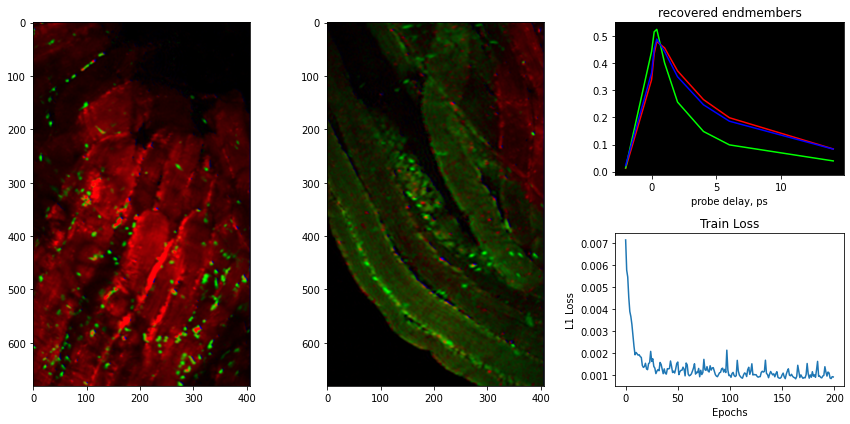

100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.87it/s]


Runs done: 1/500


 93%|██████████████████████████████████████▏  | 186/200 [00:26<00:01,  7.05it/s]


KeyboardInterrupt: 

In [6]:
loss_arr = []

# number of times the experiment is repeated
n_runs = 500
n_epochs = 200
learning_rate = 1e-2
nch_bottleneck = 3

loss_recon_arr = np.zeros(n_runs)
loss_zcorr_arr = np.zeros(n_runs)
total_loss_arr = np.zeros(n_runs)

print('Starting training of models on {}'.format(device))
n_count = 0
models = [Net() for i in range(n_runs)]
for i in range(1,n_runs+1):
    #model = Net()
    loss, img1, img2, loss_recon, loss_zcorr = train_model(models[i-1], n_epochs, img_stack, learning_rate)
    loss_arr.append((loss, img1, img2))
    loss_recon_arr[i-1] = loss_recon
    loss_zcorr_arr[i-1] = loss_zcorr
    total_loss_arr[i-1] = loss
    n_count+=1
    print('Runs done: {}/{}'.format(n_count, n_runs))

# Analyze distribution of recovered endmembers

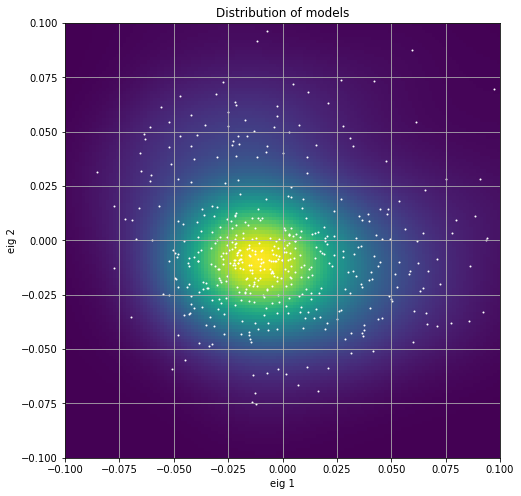

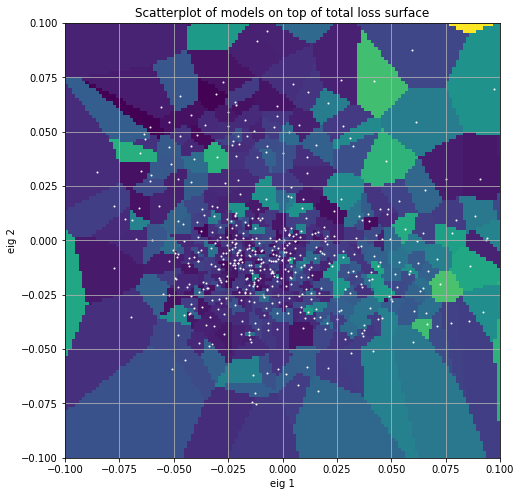

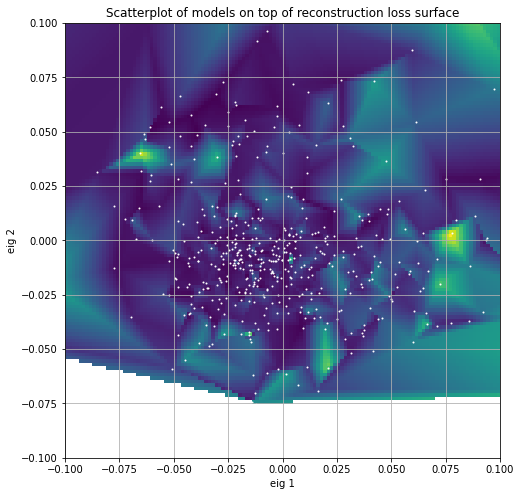

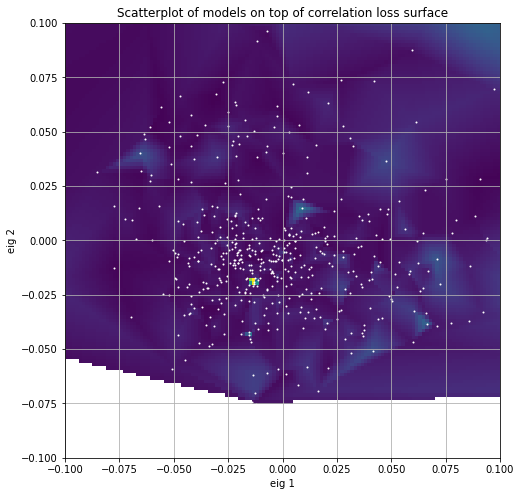

0.9999863934772886
(3, 500)


In [7]:
# generate endmember list
wlist = np.zeros((len(models),9,nch_bottleneck))
for i,model in enumerate(models):
    w = model.getSOEMlayer().weight
    w = w[:,model.indices]
    w = w.detach().cpu().numpy().squeeze()
    wlist[i,:,:] = w
    
wlist = wlist.swapaxes(2,1).reshape([n_runs,9*nch_bottleneck])
wlist[np.isnan(wlist)] = 0

# subtract off means of each column
wmeans = np.mean(wlist,axis=0)
wlistms = wlist - wmeans

# singular value decomposition
u,s,vh = np.linalg.svd(wlistms)

# plt.plot(vh[0:3,:].transpose())
# plt.xlabel('sample index')
# plt.ylabel('signal')
# plt.title('eigenvectors')
# plt.legend(['1','2','3'])
# plt.show()

pltrange= 0.1

# distribution, eigs1 vs 2
plt.figure(figsize=(8,8))
x = np.linspace(-pltrange,pltrange,128)
y = np.linspace(-pltrange,pltrange,128)
X,Y = np.meshgrid(x,y)
Z = np.zeros_like(X)
xylist = np.vstack([X.ravel(),Y.ravel(),Z.ravel()])
kernel = stats.gaussian_kde(u[0:3,:])
D = np.reshape(kernel(xylist).T,X.shape)
plt.imshow(D,origin='lower',extent=[x[0],x[-1],y[0],y[-1]])    
# plt.show()

plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Distribution of models')
plt.show()

# distribution of total loss plotted on eig1 vs eig2
plt.figure(figsize=(8,8))
x = np.linspace(-pltrange,pltrange,128)
y = np.linspace(-pltrange,pltrange,128)
X,Y = np.meshgrid(x,y)
points = (u[0,:],u[1,:])
values = total_loss_arr
grid = griddata(points, values, (X, Y), method='nearest')
plt.imshow(grid, extent=[x[0],x[-1],y[0],y[-1]], origin='lower')
# plt.show()

plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Scatterplot of models on top of total loss surface')
plt.show()

# distribution of reconstruction loss plotted on eig1 vs eig2
plt.figure(figsize=(8,8))
x = np.linspace(-pltrange,pltrange,128)
y = np.linspace(-pltrange,pltrange,128)
X,Y = np.meshgrid(x,y)
points = (u[0,:],u[1,:])
values = loss_recon_arr
grid = griddata(points, values, (X, Y), method='linear')
plt.imshow(grid, extent=[x[0],x[-1],y[0],y[-1]], origin='lower')
# plt.show()

plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Scatterplot of models on top of reconstruction loss surface')
plt.show()

# distribution of correlation loss plotted on eig1 vs eig2
plt.figure(figsize=(8,8))
x = np.linspace(-pltrange,pltrange,128)
y = np.linspace(-pltrange,pltrange,128)
X,Y = np.meshgrid(x,y)
points = (u[0,:],u[1,:])
values = loss_zcorr_arr
grid = griddata(points, values, (X, Y), method='linear')
plt.imshow(grid, extent=[x[0],x[-1],y[0],y[-1]], origin='lower')
# plt.show()

plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Scatterplot of models on top of correlation loss surface')

plt.show()

# relative probability of each model
kdeint = kernel.integrate_box([-0.5,-0.5,-0.5],[0.5,0.5,0.5])
print(kdeint)
relprob = kernel.pdf(u[0:3,:])
print(u[0:3,:].shape)
relprob = relprob / np.sum(relprob)


## Loss plots with RBF interpolation

In [8]:
pltrange= 0.1
points = np.array((u[0,:],u[1,:]))
points = points.T

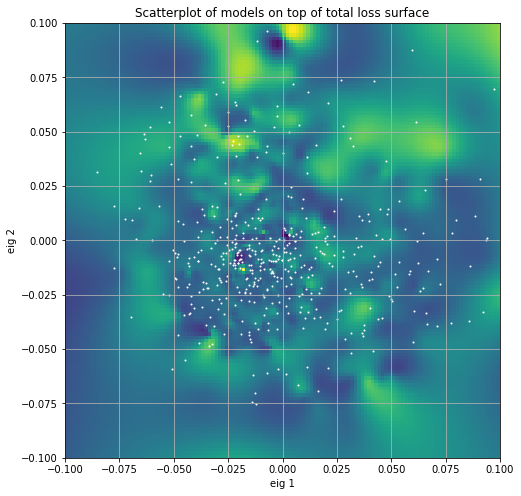

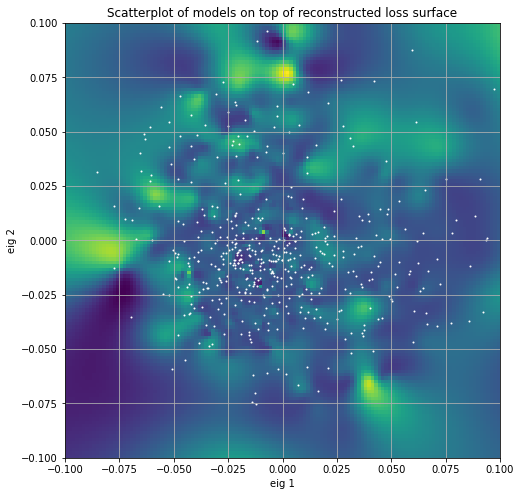

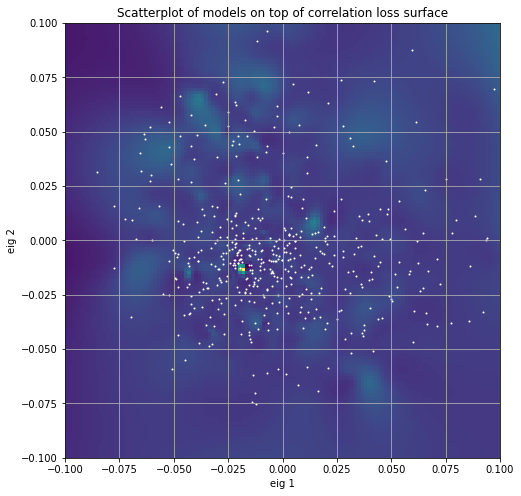

In [9]:
# distribution of total loss plotted on eig1 vs eig2

# compute the interpolated grid
values = np.array(total_loss_arr)
xgrid = np.mgrid[-.1:.1:128j, -.1:.1:128j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(points, values)(xflat)
ygrid = yflat.reshape(128, 128)

# plot the loss surface
plt.figure(figsize=(8,8))
plt.imshow(ygrid, origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Scatterplot of models on top of total loss surface')

# scatter the models on top of the loss surface
plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.show()

# compute the interpolated grid
values = np.array(loss_recon_arr)
xgrid = np.mgrid[-.1:.1:128j, -.1:.1:128j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(points, values)(xflat)
ygrid = yflat.reshape(128, 128)

# plot the loss surface
plt.figure(figsize=(8,8))
plt.imshow(ygrid, origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Scatterplot of models on top of reconstructed loss surface')

# scatter the models on top of the loss surface
plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.show()

# compute the interpolated grid
values = np.array(loss_zcorr_arr)
xgrid = np.mgrid[-.1:.1:128j, -.1:.1:128j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(points, values)(xflat)
ygrid = yflat.reshape(128, 128)

# plot the loss surface
plt.figure(figsize=(8,8))
plt.imshow(ygrid, origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('Scatterplot of models on top of correlation loss surface')

# scatter the models on top of the loss surface
plt.scatter(u[0,:],u[1,:], 1.0, marker='o', color='white', alpha = 1.0)
plt.show()

# Hover over scatterplot and plot images

In [10]:
data = np.array(loss_arr)
img_arr = []
for n in data:
    img1 = n[1]
    img_arr.append(img1)
img_arr = np.array(img_arr)
print(img_arr.shape)

/tmp/ipykernel_3297239/119353973.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(loss_arr)


(500, 681, 406, 3)


In [11]:

def viz_space(x1, y1, grid, data):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    ax.imshow(grid, origin='lower', extent=[-0.1, 0.1, -0.1, 0.1])
    ax.set_xlim((-pltrange,pltrange))
    ax.set_ylim((-pltrange,pltrange))
    ax.grid()
    ax.set_xlabel('Eigen Axis 1', fontsize = 18)
    ax.set_ylabel('Eigen Axis 2', fontsize = 18)
#     ax.set_title('Scatterplot of models on top of total loss surface', fontsize = 20)
    ax.set_title('Distribution of models in ensemble', fontsize = 20)
    
    annot_x = plt.xlim()[-1]
    annot_y = plt.ylim()[0] 
    txt = ax.text(annot_x, annot_y, "Chart Ready", 
                  ha='center', fontsize=36, color='#DD4012')
    
    # create figure and plot scatter
    figure = ax.plot(x1, y1, ls="", marker=".", label='Models', c = 'white', alpha = 1.0)
    ax.legend()
    line, = figure

    # create the annotations box
    im = OffsetImage(data[0], cmap ='gray')
    xybox=(50., 50.)
    ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
            boxcoords="offset points",  pad=2,  arrowprops=dict(arrowstyle="->"))
    # add it to the axes and make it invisible
    ax.add_artist(ab)
    ab.set_visible(False)
        
    def onclick(event):
        # if the mouse is over the scatter points
        if line.contains(event)[0]:
            # find out the index within the array from the event
            ind, = line.contains(event)[1]["ind"]
            # get the figure size
            w,h = fig.get_size_inches()*fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            # if event occurs in the top or right quadrant of the figure,
            # change the annotation box position relative to mouse.
            ab.xybox = (xybox[0]*ws, xybox[1]*hs)
            # make annotation box visible
            ab.set_visible(True)
            # place it at the position of the hovered scatter point
            ab.xy =(x1[ind]+.05, y1[ind]+.05)
            # set the image corresponding to that point
            im.set_data(data[ind])
            txt.set_text(str(ind))
        else:
            #if the mouse is not over a scatter point
            ab.set_visible(False)
        fig.canvas.draw_idle()
    # add callback for mouse moves
#     fig.canvas.mpl_connect('motion_notify_event', hover)   
    fig.canvas.mpl_connect('button_press_event', onclick)           
    plt.show()

<IPython.core.display.Javascript object>


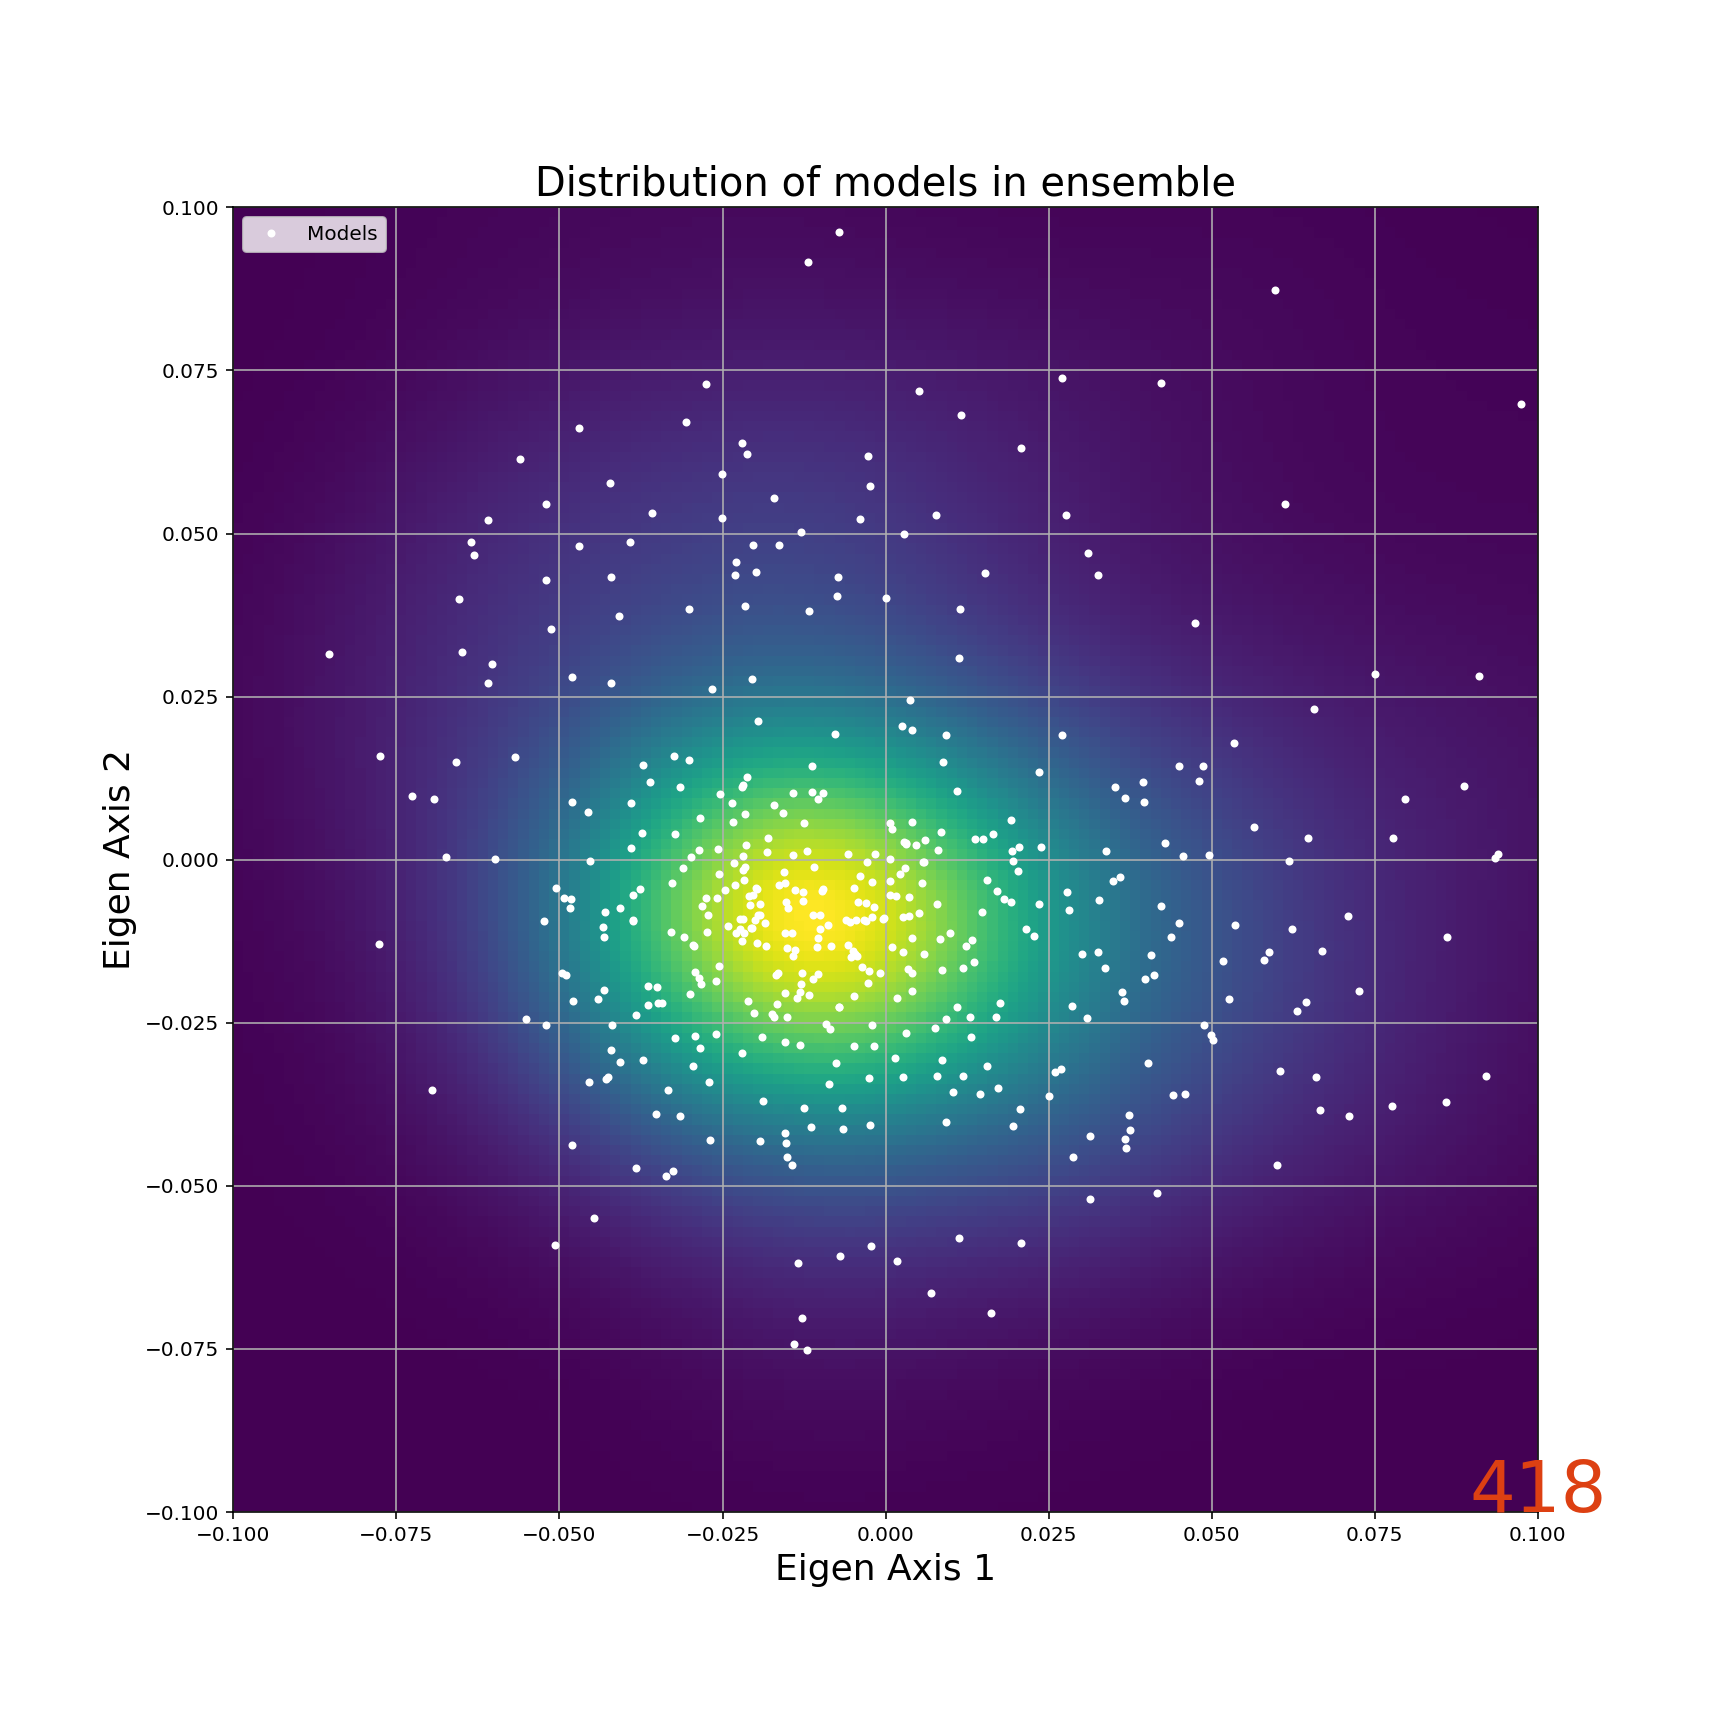

In [16]:
%matplotlib notebook
viz_space(u[0,:], u[1,:], D, img_arr)

most likely model:  140
AIC:  -24.082010589458278


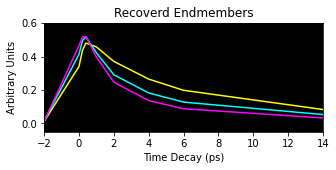

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


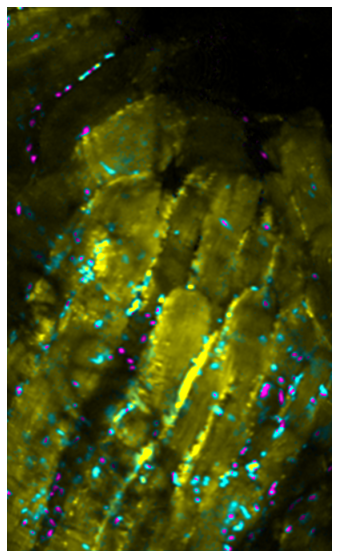

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


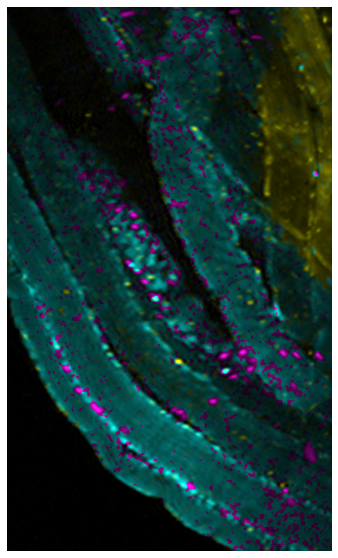

In [23]:
%matplotlib inline
def generate_z_image_onemodel(ind, model):
    nb,ny,nx,nch = img_stack.shape
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,model.indices[0:nch_bottleneck],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    if nch_bottleneck > 2:
        img_recolor[:,:,2] += img[:,:,2]
        img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

def generate_w_onemodel(model):
    w = model.getSOEMlayer().weight
    w = w[:,model.indices]
    w = w.detach().cpu().numpy().squeeze()
    return w

ind_ml = np.argmax(relprob)
print('most likely model: ', ind_ml)
# ind_ml = 387
#aic = 9*np.log(loss_recon_arr[ind_ml])+2*nch_bottleneck
aic = 9*np.log(loss_recon_arr[ind_ml])+2*(9*nch_bottleneck)
print('AIC: ', aic)

tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
w = generate_w_onemodel(models[ind_ml])

plt.figure(figsize=(5,2))
ax=plt.axes()
ax.set_facecolor('black')
plt.plot(tau,w[:,0],color='yellow')
plt.plot(tau,w[:,1],color='cyan')
if nch_bottleneck > 2:
    plt.plot(tau,w[:,2],color='magenta')
if nch_bottleneck > 3:
    plt.plot(tau,w[:,3],color='red')
    #
#for i in range(len(models)):
#    plt.plot(tau,w[i,:,0],color='yellow',alpha=alph)
#    plt.plot(tau,w[i,:,1],color='cyan',alpha=alph)
#    plt.plot(tau,w[i,:,2],color='magenta',alpha=alph)
    #plt.plot(tau,w[i,:,3],color='red',alpha=alph)
    #plt.plot(tau,w[i,:,4],color='green',alpha=2*alph)
ax.set_xlim([-2,14])
ax.set_ylim([-0.05,0.6])
ax.set_xlabel('Time Decay (ps)')
ax.set_ylabel('Arbitrary Units')
ax.set_title('Recoverd Endmembers')
plt.show()
                     

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_onemodel(0,models[ind_ml]))
plt.axis('off')
plt.show()

plt.figure(figsize=[8,10])
img = generate_z_image_onemodel(1,models[ind_ml])
# img = img[70:400,:,:]
plt.imshow(img)
plt.axis('off')
plt.show()

# plt.figure(figsize=[8,10])
# plt.imshow(generate_z_image_onemodel(2,models[ind_ml]))
# plt.show()

# plt.figure(figsize=[8,10])
# plt.imshow(generate_z_image_onemodel(5,models[ind_ml]))
# plt.show()

In [19]:
counts,edges=np.histogram(loss_recon_arr,128)
loss_recon_w = np.sum(relprob*loss_recon_arr)
print('probability-weighted recon loss: ', loss_recon_w)
loss_recon_ml = edges[np.argmax(counts)]
print('most likely recon loss: ', loss_recon_ml)
#aic = 9*np.log(loss_recon_ml)+2*nch_bottleneck
aic = 9*np.log(loss_recon_ml)+9*nch_bottleneck+3
print('AIC: ', aic)

plt.plot(edges[1:],counts)
plt.vlines(loss_recon_w,0,max(counts))
plt.xlabel('reconstruction loss')
plt.ylabel('model count')
plt.title('reconstruction loss histogram')
plt.plot()

loss_recon_w = np.sum(relprob*loss_recon_arr)


probability-weighted recon loss:  0.00020828142655233625
most likely recon loss:  0.0001862619908479246
AIC:  -47.29520690146853


In [20]:
np.max(relprob)

0.005164407670977354

In [21]:
counts,edges=np.histogram(relprob,128)
plt.plot(edges[1:],counts)
plt.show()
print(np.percentile(relprob,90))
print(np.max(relprob))
print(np.argwhere(relprob > np.percentile(relprob,90)))

0.0044017573379885756
0.005164407670977354
[[  3]
 [ 28]
 [ 34]
 [ 38]
 [ 47]
 [ 49]
 [ 53]
 [ 70]
 [ 74]
 [ 97]
 [122]
 [127]
 [140]
 [141]
 [156]
 [160]
 [165]
 [172]
 [180]
 [187]
 [191]
 [194]
 [196]
 [213]
 [236]
 [239]
 [249]
 [253]
 [279]
 [290]
 [293]
 [295]
 [296]
 [308]
 [324]
 [336]
 [387]
 [389]
 [409]
 [415]
 [435]
 [449]
 [450]
 [458]
 [463]
 [470]
 [483]
 [486]
 [494]
 [497]]


# Estimate endmembers and abundances based on relative probability weighting of models

(9, 3)


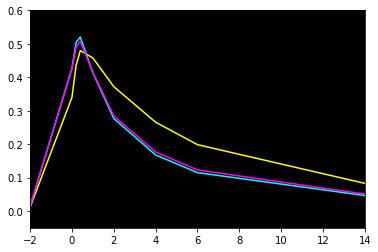

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


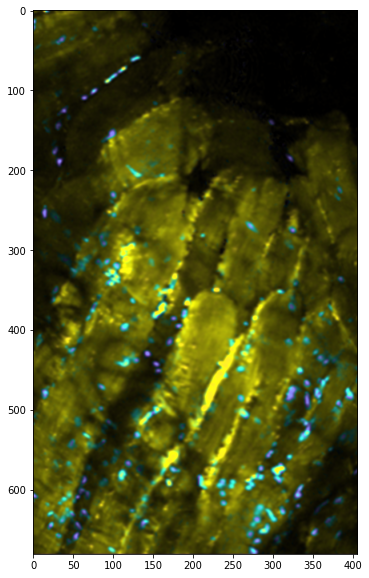

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


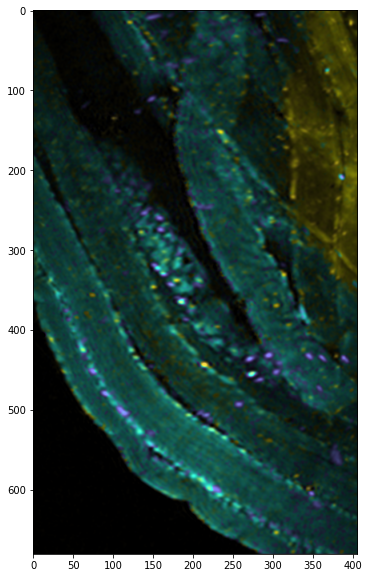

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


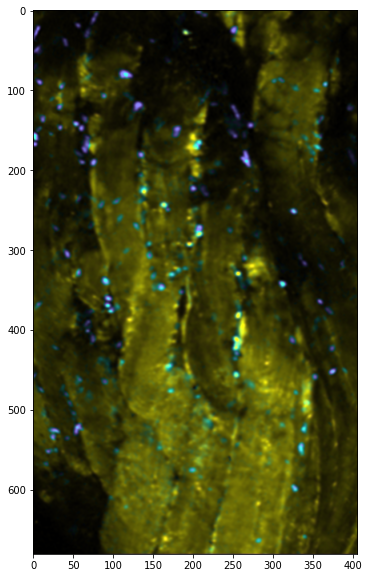

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


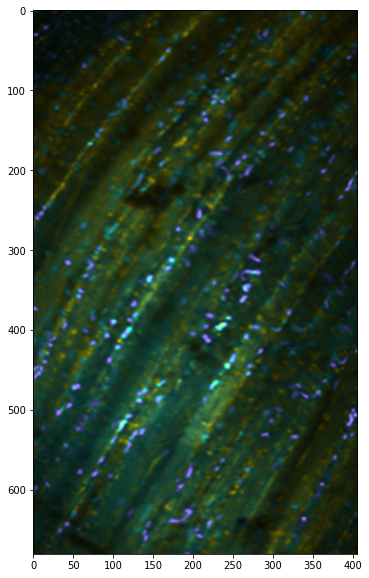

In [24]:
def generate_z_image_ensembled(ind, models):
    nb,ny,nx,nch = img_stack.shape
    img = np.zeros((len(models),ny,nx,nch_bottleneck))
    for i, model in enumerate(models):
        data = img_stack[ind,:,:,:]
        data = data[None,:]
        data = data.to(device)
        out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
        out = out[0,model.indices[0:nch_bottleneck],:,:]
        out = torch.permute(out, (1,2,0))
        img[i] = relprob[i]*out.detach().cpu().numpy()
        #img[i] = out.detach().cpu().numpy()
        
    #img = img/len(models)
    #img = np.mean(img,axis=0).squeeze()
    img[np.isnan(img)]=0
    img = np.sum(img,axis=0).squeeze()
    #nbin = 50
    #ret = mode((nbin*img).astype(np.int),axis=0)
    #img = ret.mode.astype(np.float)/nbin
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    if nch_bottleneck > 2:
        img_recolor[:,:,2] += img[:,:,2]
        img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

def generate_w_ensembled(models):
    wlist = np.zeros((len(models),9,nch_bottleneck))
    for i,model in enumerate(models):
        w = model.getSOEMlayer().weight
        w = w[:,model.indices]
        w = w.detach().cpu().numpy().squeeze()
        w[np.isnan(w)]=0
        wlist[i,:,:] = relprob[i] * w
        #
        
    return np.sum(wlist,axis=0)
    #return wlist
        
%matplotlib inline
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
w = generate_w_ensembled(models)
print(w.shape)
alph = 20/len(models)
#alph=0.03
ax=plt.axes()
ax.set_facecolor('black')
plt.plot(tau,w[:,0],color='yellow')
plt.plot(tau,w[:,1],color='cyan')
if nch_bottleneck > 2:
    plt.plot(tau,w[:,2],color='magenta')
if nch_bottleneck > 3:
    plt.plot(tau,w[:,3],color='red')
    #
#for i in range(len(models)):
#    plt.plot(tau,w[i,:,0],color='yellow',alpha=alph)
#    plt.plot(tau,w[i,:,1],color='cyan',alpha=alph)
#    plt.plot(tau,w[i,:,2],color='magenta',alpha=alph)
    #plt.plot(tau,w[i,:,3],color='red',alpha=alph)
    #plt.plot(tau,w[i,:,4],color='green',alpha=2*alph)
ax.set_xlim([-2,14])
ax.set_ylim([-0.05,0.6])
plt.show()
                     

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(0,models))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(1,models))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(2,models))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(5,models))
plt.show()

# Endmembers and abundances based on most likely model

# Average top most likely models

500
(9, 3)


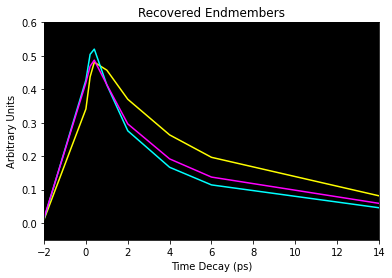

500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


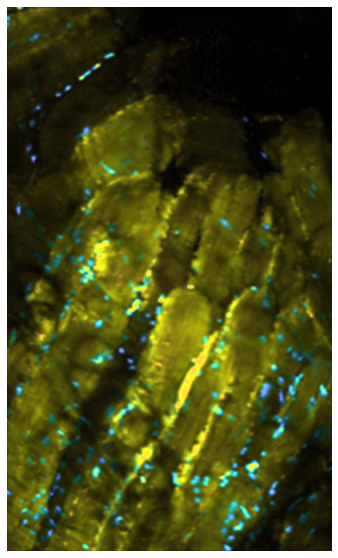

500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


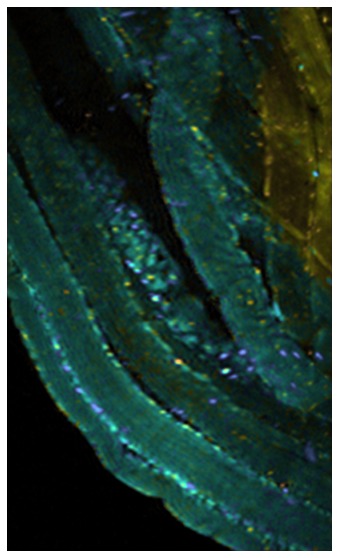

In [25]:
%matplotlib inline
def generate_z_image_ensembled(ind, models):
    print(len(models))
    nb,ny,nx,nch = img_stack.shape
    img = np.zeros((len(models),ny,nx,nch_bottleneck))
    for i, model in enumerate(models):
        data = img_stack[ind,:,:,:]
        data = data[None,:]
        data = data.to(device)
        out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
        out = out[0,model.indices[0:nch_bottleneck],:,:]
        out = torch.permute(out, (1,2,0))
        img[i] =out.detach().cpu().numpy()
        #img[i] = out.detach().cpu().numpy()
        
    #img = img/len(models)
    img = np.mean(img,axis=0).squeeze()
    img[np.isnan(img)]=0
    #mg = np.median(img,axis=0).squeeze()
    #nbin = 50
    #ret = mode((nbin*img).astype(np.int),axis=0)
    #img = ret.mode.astype(np.float)/nbin
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,2]
    img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

def generate_w_ensembled(models):
    wlist = np.zeros((len(models),9,nch_bottleneck))
    for i,model in enumerate(models):
        w = model.getSOEMlayer().weight
        w = w[:,model.indices]
        w = w.detach().cpu().numpy().squeeze()
        w[np.isnan(w)]=0
        wlist[i,:,:] = w
        #
        
    return np.mean(wlist,axis=0)
    #return wlist
        
minpr = np.percentile(relprob,0)
models_sel = []
for i in range(n_runs):
    if relprob[i] >= minpr:
        models_sel.append(models[i])

print(len(models_sel))
        
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
w = generate_w_ensembled(models_sel)
print(w.shape)
alph = 20/len(models)
#alph=0.03
ax=plt.axes()
ax.set_facecolor('black')
plt.plot(tau,w[:,0],color='yellow')
plt.plot(tau,w[:,1],color='cyan')
plt.plot(tau,w[:,2],color='magenta')
if nch_bottleneck > 3:
    plt.plot(tau,w[:,3],color='red')
    #
#for i in range(len(models)):
#    plt.plot(tau,w[i,:,0],color='yellow',alpha=alph)
#    plt.plot(tau,w[i,:,1],color='cyan',alpha=alph)
#    plt.plot(tau,w[i,:,2],color='magenta',alpha=alph)
    #plt.plot(tau,w[i,:,3],color='red',alpha=alph)
    #plt.plot(tau,w[i,:,4],color='green',alpha=2*alph)
ax.set_xlim([-2,14])
ax.set_ylim([-0.05,0.6])
ax.set_title('Recovered Endmembers')
ax.set_xlabel('Time Decay (ps)')
ax.set_ylabel('Arbitrary Units')
plt.show()
                     

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(0,models_sel))
plt.axis('off')
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(1,models_sel))
plt.axis('off')
plt.show()

#plt.figure(figsize=[8,10])
#plt.imshow(generate_z_image_ensembled(2,models))
#plt.show()

#plt.figure(figsize=[8,10])
#plt.imshow(generate_z_image_ensembled(5,models))
#plt.show()

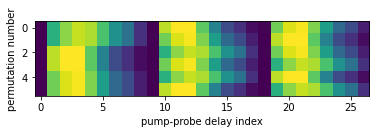

In [27]:
from itertools import permutations

permobj = permutations([0,1,2])
nperms = np.math.factorial(nch_bottleneck)
perms = np.zeros((nperms,nch_bottleneck))
for iperm,perm in enumerate(permobj):
    perms[iperm,:] = perm
    
model = models[1]

w = model.getSOEMlayer().weight
wlist = np.zeros((nperms,9,nch_bottleneck))

for iperm,perm in enumerate(perms):
    wlist[iperm,:,:] = w[:,perm].squeeze().cpu().detach().numpy()
    
wlist = wlist.swapaxes(2,1).reshape([nperms,9*nch_bottleneck])
wlist[np.isnan(wlist)] = 0
    
plt.imshow(wlist)
plt.ylabel('permutation number')
plt.xlabel('pump-probe delay index')
plt.show()

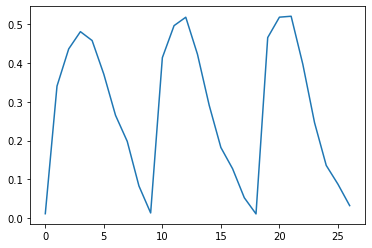

In [28]:
wref = models[ind_ml].getSOEMlayer().weight[:,models[ind_ml].indices].cpu().detach().numpy().squeeze()
wref=wref[None,:]
wref = wref.swapaxes(2,1).reshape([1,9*nch_bottleneck])
wref.shape
plt.plot(wref.T)

In [29]:
ind_matching_perm = np.argmax(np.sum(wlist * wref,1))
print(ind_matching_perm)
perms[ind_matching_perm]

1


array([0., 2., 1.])

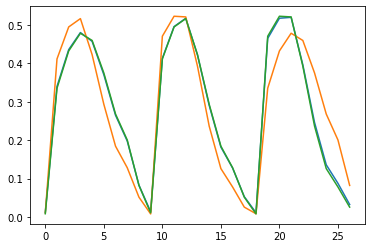

In [33]:
wvarsrt = model.getSOEMlayer().weight[:,model.indices].cpu().detach().numpy().squeeze()
wvarsrt=wvarsrt[None,:]
wvarsrt = wvarsrt.swapaxes(2,1).reshape([1,9*nch_bottleneck])

plt.plot(wref.T)
plt.plot(wlist[5,:].T)
plt.plot(wvarsrt.T)
plt.show()

In [35]:
# reference model (most likely)
wref = models[ind_ml].getSOEMlayer().weight[:,models[ind_ml].indices].cpu().detach().numpy().squeeze()
wref=wref[None,:]
wref = wref.swapaxes(2,1).reshape([1,9*nch_bottleneck])

# permutations set-up
permobj = permutations([0,1,2])
nperms = np.math.factorial(nch_bottleneck)
perms = np.zeros((nperms,nch_bottleneck))
for iperm,perm in enumerate(permobj):
    perms[iperm,:] = perm
    
# iterate through all models
for model in models:

    w = model.getSOEMlayer().weight
    wlist = np.zeros((nperms,9,nch_bottleneck))

    # generate permutations of endmembers for this model
    for iperm,perm in enumerate(perms):
        wlist[iperm,:,:] = w[:,perm].squeeze().cpu().detach().numpy()

    wlist = wlist.swapaxes(2,1).reshape([nperms,9*nch_bottleneck])
    wlist[np.isnan(wlist)] = 0
    
    # find permutation that best matches the reference model
    ind_matching_perm = np.argmax(np.sum(wlist * wref,1))
    
    # store best-matching permutation in the model
    model.indices = perms[ind_matching_perm]
    
    

500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


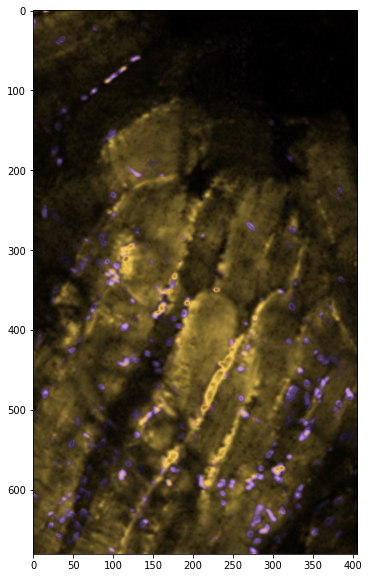

500


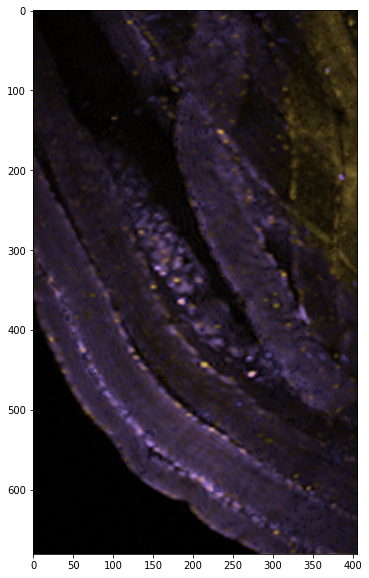

In [308]:
def generate_z_image_std(ind, models):
    print(len(models))
    nb,ny,nx,nch = img_stack.shape
    img = np.zeros((len(models),ny,nx,nch_bottleneck))
    for i, model in enumerate(models):
        data = img_stack[ind,:,:,:]
        data = data[None,:]
        data = data.to(device)
        out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
        out = out[0,model.indices[0:nch_bottleneck],:,:]
        out = torch.permute(out, (1,2,0))
        img[i] =out.detach().cpu().numpy()
        #img[i] = out.detach().cpu().numpy()
        
    #img = img/len(models)
    img = np.std(img,axis=0).squeeze()
    img[np.isnan(img)]=0
    #mg = np.median(img,axis=0).squeeze()
    #nbin = 50
    #ret = mode((nbin*img).astype(np.int),axis=0)
    #img = ret.mode.astype(np.float)/nbin
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,2]
    img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_std(0,models_sel))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_std(1,models_sel))
plt.show()


In [ ]:
for x in loss_arr:
    print("Loss: ", x[0])
    plt.subplot(1,2,1)
    plt.imshow(x[1])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(x[2])
    plt.axis('off')
    plt.show()

# PCA and SVD analysis

In [256]:
red_perm = []
ox_perm = []
red_intact = []
ox_intact = []

for files in filenames:
    if 'red perm' in files:
        img = io.imread(data_dir + files)
        red_perm.append(img)
        
    if 'ox perm' in files:
        img = io.imread(data_dir + files)
        ox_perm.append(img)
        
    if 'red intact' in files:
        img = io.imread(data_dir + files)
        red_intact.append(img)
        
    if 'ox intact' in files:
        img = io.imread(data_dir + files)
        ox_intact.append(img)

red_perm = np.array(red_perm)
ox_perm = np.array(ox_perm)
red_intact = np.array(red_intact)
ox_intact = np.array(ox_intact)    

print('red_perm shape = {}, ox_perm shape = {}, red_intact shape = {}, ox_intact shape = {}'.format(red_perm.shape, 
     ox_perm.shape, red_intact.shape, ox_intact.shape))

red_perm = red_perm.astype('float32')
ox_perm = ox_perm.astype('float32')
red_intact = red_intact.astype('float32')
ox_intact = ox_intact.astype('float32')

img_stack_rp = torch.tensor(red_perm)
img_stack_rp = img_stack_rp.to(device)
img_stack_op = torch.tensor(ox_perm)
img_stack_op = img_stack_op.to(device)
img_stack_ri = torch.tensor(red_intact)
img_stack_ri = img_stack_ri.to(device)
img_stack_oi = torch.tensor(ox_intact)
img_stack_oi = img_stack_oi.to(device)

model = models[ind_ml]

preds = []
for data in img_stack:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds.append(img)
preds = np.array(preds)
print(preds.shape)

preds_rp = []
for data in img_stack_rp:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_rp.append(img)
preds_rp = np.array(preds_rp)
print(preds_rp.shape)

preds_op = []
for data in img_stack_op:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_op.append(img)
preds_op = np.array(preds_op)
print(preds_op.shape)

preds_ri = []
for data in img_stack_ri:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_ri.append(img)
preds_ri = np.array(preds_ri)
print(preds_ri.shape)

preds_oi = []
for data in img_stack_oi:
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    preds_oi.append(img)
preds_oi = np.array(preds_oi)
print(preds_oi.shape)

preds = np.swapaxes(preds, 0, 3)
print(preds.shape)
preds_rp = np.swapaxes(preds_rp, 0, 3)
print(preds_rp.shape)
preds_op = np.swapaxes(preds_op, 0, 3)
print(preds_op.shape)
preds_ri = np.swapaxes(preds_ri, 0, 3)
print(preds_ri.shape)
preds_oi = np.swapaxes(preds_oi, 0, 3)
print(preds_oi.shape)

"convert data from [M, nx, ny, c] to [c, (M*nx*ny)] shape"
preds_rolled = []
for img in preds:
    rolled_img = np.ravel(img)
    preds_rolled.append(rolled_img)
preds_rolled = np.array(preds_rolled)
print(preds_rolled.shape)

preds_rolled_rp = []
for img in preds_rp:
    rolled_img = np.ravel(img)
    preds_rolled_rp.append(rolled_img)
preds_rolled_rp = np.array(preds_rolled_rp)
print(preds_rolled_rp.shape)

preds_rolled_op = []
for img in preds_op:
    rolled_img = np.ravel(img)
    preds_rolled_op.append(rolled_img)
preds_rolled_op = np.array(preds_rolled_op)
print(preds_rolled_op.shape)

preds_rolled_ri = []
for img in preds_ri:
    rolled_img = np.ravel(img)
    preds_rolled_ri.append(rolled_img)
preds_rolled_ri = np.array(preds_rolled_ri)
print(preds_rolled_ri.shape)

preds_rolled_oi = []
for img in preds_oi:
    rolled_img = np.ravel(img)
    preds_rolled_oi.append(rolled_img)
preds_rolled_oi = np.array(preds_rolled_oi)
print(preds_rolled_oi.shape)

red_perm shape = (8, 681, 406, 9), ox_perm shape = (5, 681, 406, 9), red_intact shape = (6, 681, 406, 9), ox_intact shape = (6, 681, 406, 9)
(25, 681, 406, 3)
(8, 681, 406, 3)
(5, 681, 406, 3)
(6, 681, 406, 3)
(6, 681, 406, 3)
(3, 681, 406, 25)
(3, 681, 406, 8)
(3, 681, 406, 5)
(3, 681, 406, 6)
(3, 681, 406, 6)
(3, 6912150)
(3, 2211888)
(3, 1382430)
(3, 1658916)
(3, 1658916)


In [257]:
print(model.indices)

[1. 2. 0.]


# Implement SVD

In [46]:
img_stack_np = img_stack.detach().cpu().numpy().squeeze()
print(img_stack_np.shape)
img_stack_np = np.swapaxes(img_stack_np, 0 , 3)
print(img_stack_np.shape)

img_stack_rp = img_stack_rp.detach().cpu().numpy().squeeze()
print(img_stack_rp.shape)
img_stack_rp = np.swapaxes(img_stack_rp, 0 , 3)
print(img_stack_rp.shape)

img_stack_op = img_stack_op.detach().cpu().numpy().squeeze()
print(img_stack_op.shape)
img_stack_op = np.swapaxes(img_stack_op, 0 , 3)
print(img_stack_op.shape)

img_stack_ri = img_stack_ri.detach().cpu().numpy().squeeze()
print(img_stack_ri.shape)
img_stack_ri = np.swapaxes(img_stack_ri, 0 , 3)
print(img_stack_ri.shape)

img_stack_oi = img_stack_oi.detach().cpu().numpy().squeeze()
print(img_stack_oi.shape)
img_stack_oi = np.swapaxes(img_stack_oi, 0 , 3)
print(img_stack_oi.shape)

(25, 681, 406, 9)
(9, 681, 406, 25)
(8, 681, 406, 9)
(9, 681, 406, 8)
(5, 681, 406, 9)
(9, 681, 406, 5)
(6, 681, 406, 9)
(9, 681, 406, 6)
(6, 681, 406, 9)
(9, 681, 406, 6)


In [47]:
# convert data from [M, nx, ny, c] to [c, (M*nx*ny)] shape

img_stack_rolled = []
for img in img_stack_np:
    rolled_img = np.ravel(img)
    img_stack_rolled.append(rolled_img)
img_stack_rolled = np.array(img_stack_rolled)
print(img_stack_rolled.shape)

img_stack_rolled_rp = []
for img in img_stack_rp:
    rolled_img = np.ravel(img)
    img_stack_rolled_rp.append(rolled_img)
img_stack_rolled_rp = np.array(img_stack_rolled_rp)
print(img_stack_rolled_rp.shape)

img_stack_rolled_op = []
for img in img_stack_op:
    rolled_img = np.ravel(img)
    img_stack_rolled_op.append(rolled_img)
img_stack_rolled_op = np.array(img_stack_rolled_op)
print(img_stack_rolled_op.shape)

img_stack_rolled_ri = []
for img in img_stack_ri:
    rolled_img = np.ravel(img)
    img_stack_rolled_ri.append(rolled_img)
img_stack_rolled_ri = np.array(img_stack_rolled_ri)
print(img_stack_rolled_ri.shape)

img_stack_rolled_oi = []
for img in img_stack_oi:
    rolled_img = np.ravel(img)
    img_stack_rolled_oi.append(rolled_img)
img_stack_rolled_oi = np.array(img_stack_rolled_oi)
print(img_stack_rolled_oi.shape)

(9, 6912150)
(9, 2211888)
(9, 1382430)
(9, 1658916)
(9, 1658916)


In [48]:
# swap axes to feed data in PCA algorithm
img_stack_rolled = np.swapaxes(img_stack_rolled, 0, 1)
print(img_stack_rolled.shape)
img_stack_rolled_rp = np.swapaxes(img_stack_rolled_rp, 0, 1)
print(img_stack_rolled_rp.shape)
img_stack_rolled_op = np.swapaxes(img_stack_rolled_op, 0, 1)
print(img_stack_rolled_op.shape)
img_stack_rolled_ri = np.swapaxes(img_stack_rolled_ri, 0, 1)
print(img_stack_rolled_ri.shape)
img_stack_rolled_oi = np.swapaxes(img_stack_rolled_oi, 0, 1)
print(img_stack_rolled_oi.shape)

(6912150, 9)
(2211888, 9)
(1382430, 9)
(1658916, 9)
(1658916, 9)


In [49]:
# apply PCA and report metrics
svd = TruncatedSVD(n_components=3)
svd.fit(img_stack_rolled)
print('SVD explained variance ratio with these components:', svd.explained_variance_ratio_)
print('SVD singular values:', svd.singular_values_)

SVD explained variance ratio with these components: [0.95430773 0.02679579 0.00241536]
SVD singular values: [1460.8552    136.94098    41.544857]


In [50]:
stack_svd = svd.transform(img_stack_rolled)
print(stack_svd.shape)
stack_svd_rp = svd.transform(img_stack_rolled_rp)
print(stack_svd_rp.shape)
stack_svd_op = svd.transform(img_stack_rolled_op)
print(stack_svd_op.shape)
stack_svd_ri = svd.transform(img_stack_rolled_ri)
print(stack_svd_ri.shape)
stack_svd_oi = svd.transform(img_stack_rolled_oi)
print(stack_svd_oi.shape)

(6912150, 3)
(2211888, 3)
(1382430, 3)
(1658916, 3)
(1658916, 3)


In [51]:
stack_svd = np.swapaxes(stack_svd, 0, 1)
print(stack_svd.shape)
stack_svd_rp = np.swapaxes(stack_svd_rp, 0, 1)
print(stack_svd_rp.shape)
stack_svd_op = np.swapaxes(stack_svd_op, 0, 1)
print(stack_svd_op.shape)
stack_svd_ri = np.swapaxes(stack_svd_ri, 0, 1)
print(stack_svd_ri.shape)
stack_svd_oi = np.swapaxes(stack_svd_oi, 0, 1)
print(stack_svd_oi.shape)

(3, 6912150)
(3, 2211888)
(3, 1382430)
(3, 1658916)
(3, 1658916)


In [52]:
# reshape the data back to regular image sizes
stack_svd_reshaped = []
for data in stack_svd:
    data = np.reshape(data, (681, 406, 25))
    stack_svd_reshaped.append(data)
stack_svd_reshaped = np.array(stack_svd_reshaped)
print(stack_svd_reshaped.shape)
stack_svd_reshaped = np.swapaxes(stack_svd_reshaped, 0, 3)
print(stack_svd_reshaped.shape)

(3, 681, 406, 25)
(25, 681, 406, 3)


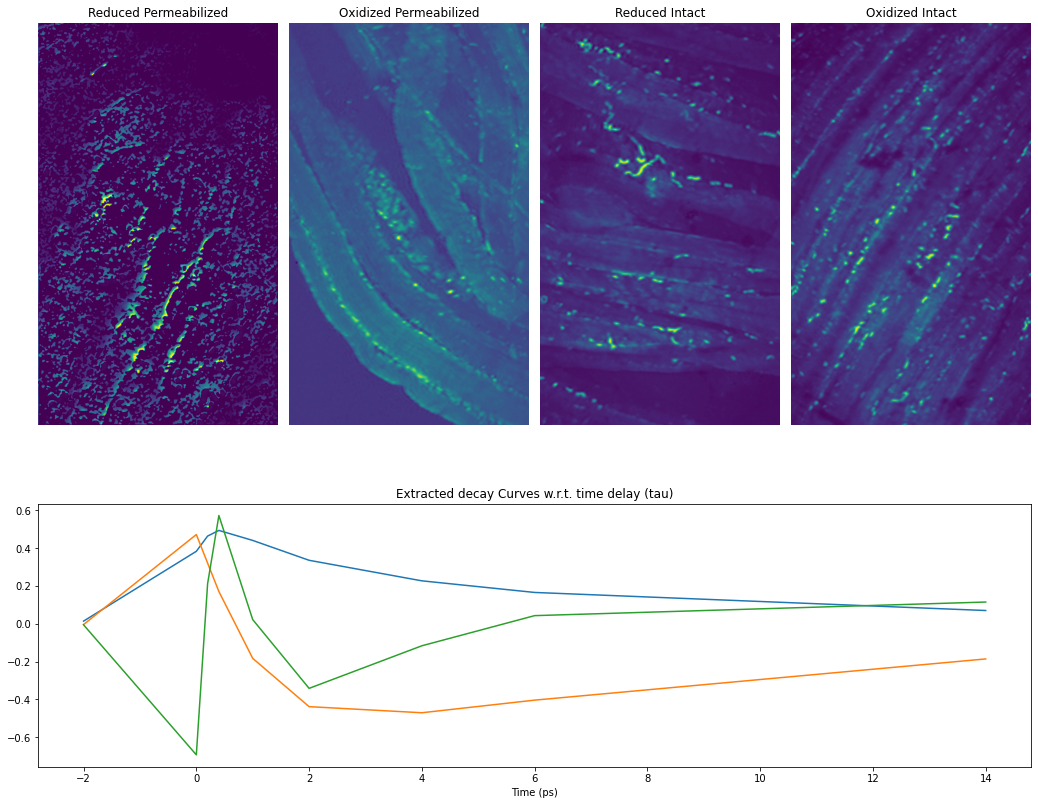

In [232]:
# creating grid for subplots
endm = 0
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(18)
 
ax1 = plt.subplot2grid(shape=(3, 5), loc=(0, 0), rowspan=2)
ax2 = plt.subplot2grid(shape=(3, 5), loc=(0, 1), rowspan=2)
ax3 = plt.subplot2grid(shape=(3, 5), loc=(0, 2), rowspan=2)
ax4 = plt.subplot2grid(shape=(3, 5), loc=(0, 3), rowspan=2)
ax5 = plt.subplot2grid(shape=(3, 5), loc=(2, 0), colspan=4)
 
# plotting subplots
# ax1.imshow(stack_svd_reshaped[0,:,:,endm])
ax1.imshow(preds[0,:,:,endm])
ax1.set_title('Reduced Permeabilized')
ax1.set_axis_off()
ax2.imshow(stack_svd_reshaped[1,:,:,endm])
ax2.set_axis_off()
ax2.set_title('Oxidized Permeabilized')
ax3.imshow(stack_svd_reshaped[4,:,:,endm])
ax3.set_axis_off()
ax3.set_title('Reduced Intact')
ax4.imshow(stack_svd_reshaped[5,:,:,endm])
ax4.set_axis_off()
ax4.set_title('Oxidized Intact')
ax5.plot(tau, np.transpose(svd.components_))
ax5.set_title('Extracted decay Curves w.r.t. time delay (tau)')
ax5.set_xlabel('Time (ps)')
 
# automatically adjust padding horizontally
# as well as vertically.
plt.tight_layout()
 
# display plot
plt.show()

### NN vs. SVD comparisons in terms of histogram distributions Feature 1 vs. Feature 2

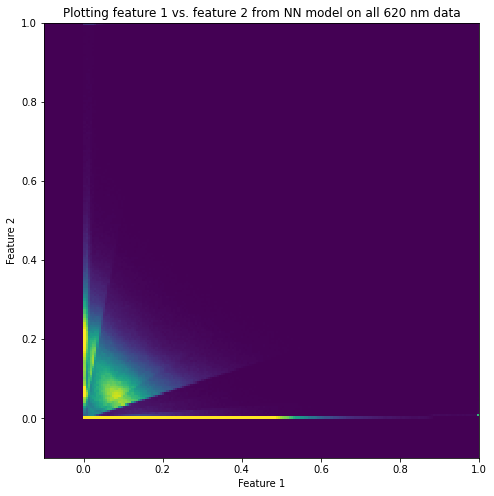

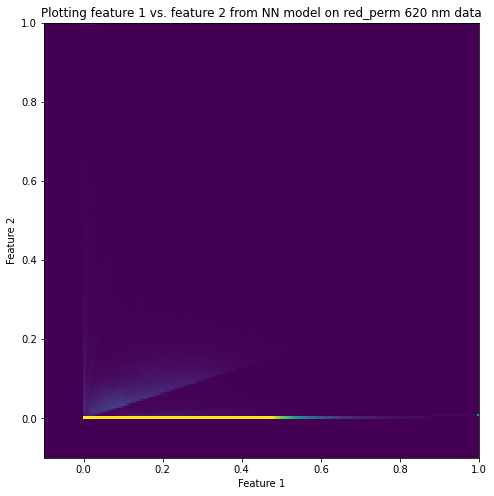

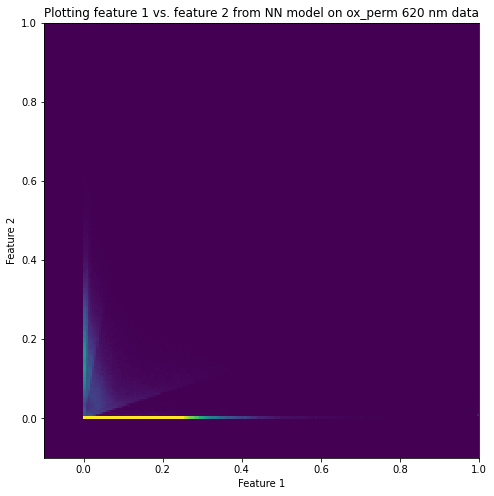

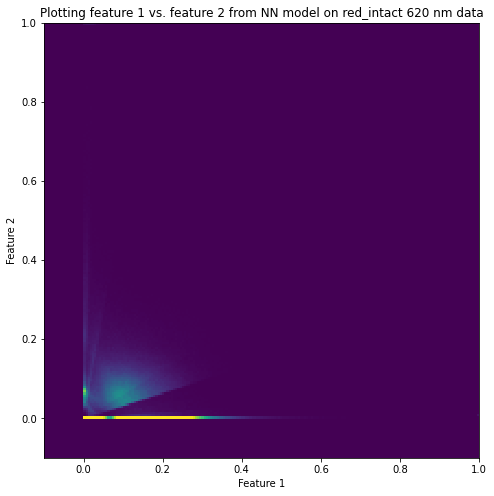

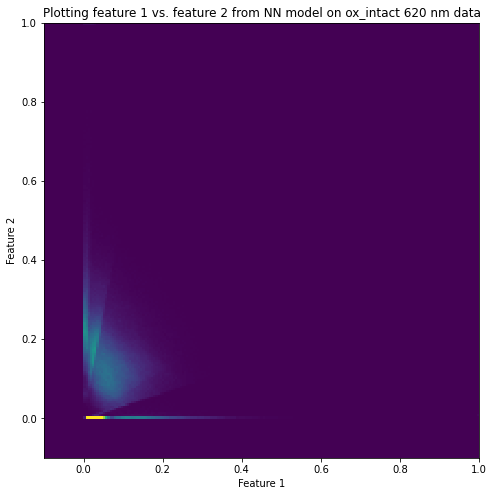

In [315]:
"""histograms for NN model"""
eps = 1e-7
ind1 = int(model.indices[0])
ind2 = int(model.indices[1])

# histogram for all predictions
x = preds_rolled[ind1,:]
y = preds_rolled[ind2,:]

xedges = np.linspace(-0.1, 1, 200)
yedges = np.linspace(-0.1, 1, 200)

hist, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist = hist.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on all 620 nm data')
plt.show()

# histogram for red_perm predictions
x = preds_rolled_rp[ind1,:]
y = preds_rolled_rp[ind2,:]


hist_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_rp = hist_rp.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_rp + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_rp, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on red_perm 620 nm data')
plt.show()

# histogram for ox perm predictions
x = preds_rolled_op[ind1,:]
y = preds_rolled_op[ind2,:]


hist_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_op = hist_op.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_op + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_op, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on ox_perm 620 nm data')
plt.show()

# histogram for reduced intact predictions
x = preds_rolled_ri[ind1,:]
y = preds_rolled_ri[ind2,:]

hist_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_ri = hist_ri.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_ri + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_ri, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on red_intact 620 nm data')
plt.show()


# histogram for oxidized intact predictions
x = preds_rolled_oi[ind1,:]
y = preds_rolled_oi[ind2,:]


hist_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_oi = hist_oi.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_oi + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_oi, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from NN model on ox_intact 620 nm data')
plt.show()

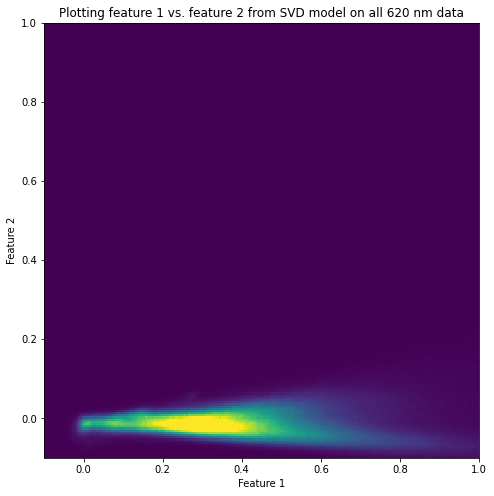

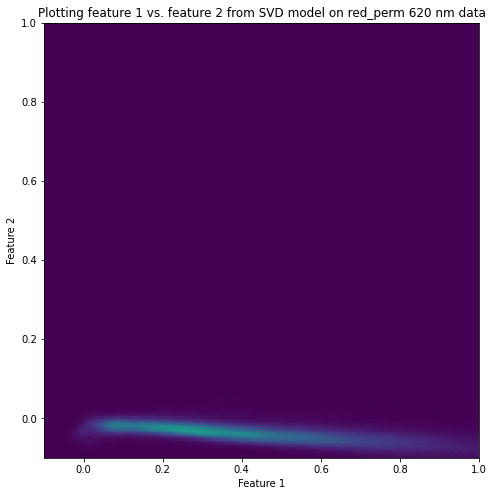

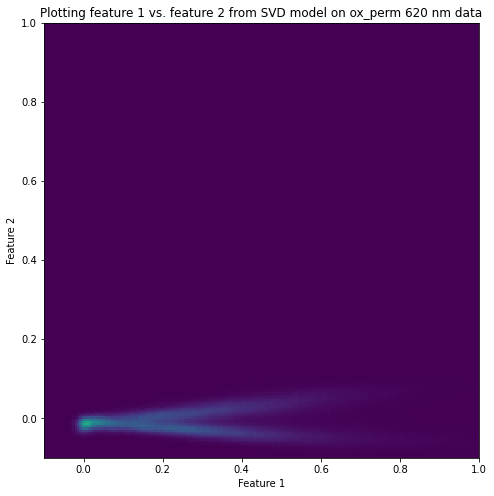

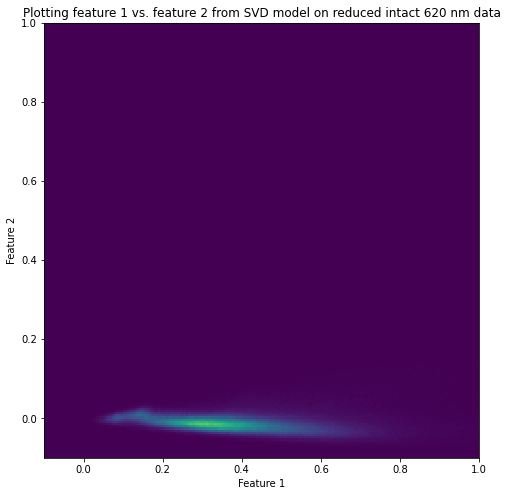

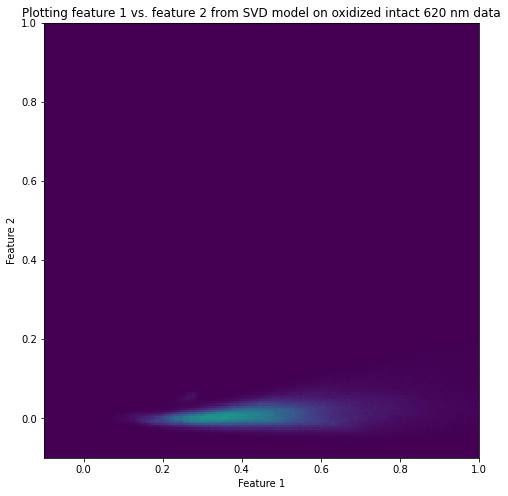

In [316]:
# plot 2D histogram of the SVD analysis
plot_ind1 = 0
plot_ind2 = 1

x = stack_svd[plot_ind1, :]
y = stack_svd[plot_ind2, :]

hist_svd, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd = hist_svd.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.imshow(hist_svd, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on all 620 nm data')
plt.show()


x = stack_svd_rp[plot_ind1, :]
y = stack_svd_rp[plot_ind2, :]

hist_svd_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_rp = hist_svd_rp.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_rp + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_rp, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on red_perm 620 nm data')
plt.show()


x = stack_svd_op[plot_ind1, :]
y = stack_svd_op[plot_ind2, :]

hist_svd_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_op = hist_svd_op.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_op + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_op, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on ox_perm 620 nm data')
plt.show()


x = stack_svd_ri[plot_ind1, :]
y = stack_svd_ri[plot_ind2, :]

hist_svd_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_ri = hist_svd_ri.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_ri + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_ri, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on reduced intact 620 nm data')
plt.show()


x = stack_svd_oi[plot_ind1, :]
y = stack_svd_oi[plot_ind2, :]

hist_svd_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_oi = hist_svd_oi.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_oi + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_oi, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plotting feature 1 vs. feature 2 from SVD model on oxidized intact 620 nm data')
plt.show()

In [317]:
"define parameters"
div = 12
norm = 10000/2
alpha = 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


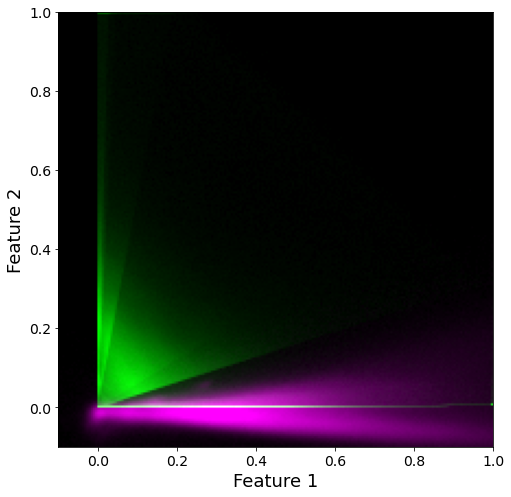

In [318]:
"For all data"
H1 = hist/norm
H2 = hist_svd/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H2
rgb[:,:,1] = H1
rgb[:,:,2] = H2
plt.figure(figsize=(8,8))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[-1], yedges[0]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1', fontsize = 18)
plt.ylabel('Feature 2', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.title('Distribution of endmembers for all data recovered by the Neural Network and SVD methods', fontsize = 20)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


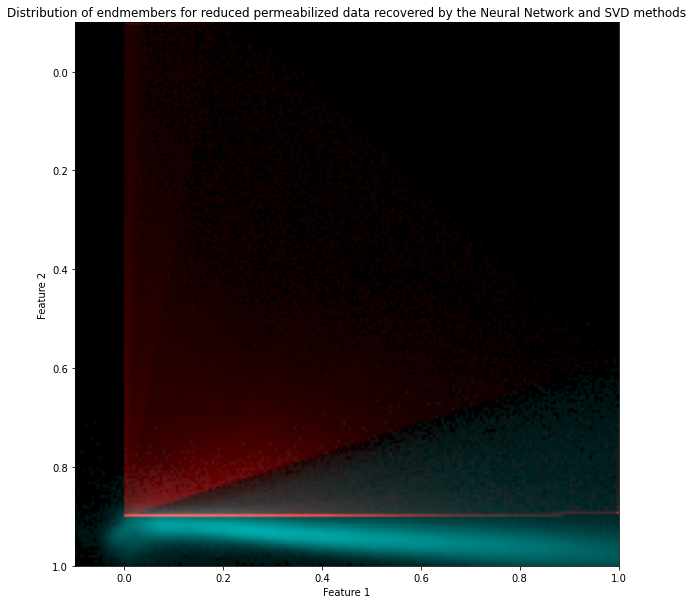

In [264]:
" For Reduced Permeabilized data"
H1 = hist_rp
H2 = hist_svd_rp
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of endmembers for reduced permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


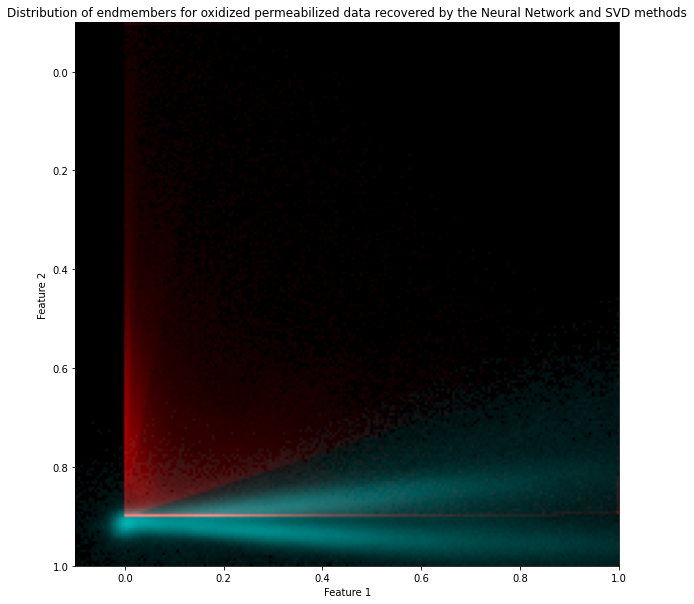

In [265]:
" For Oxidized Permeabilized data"
H1 = hist_op
H2 = hist_svd_op
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of endmembers for oxidized permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


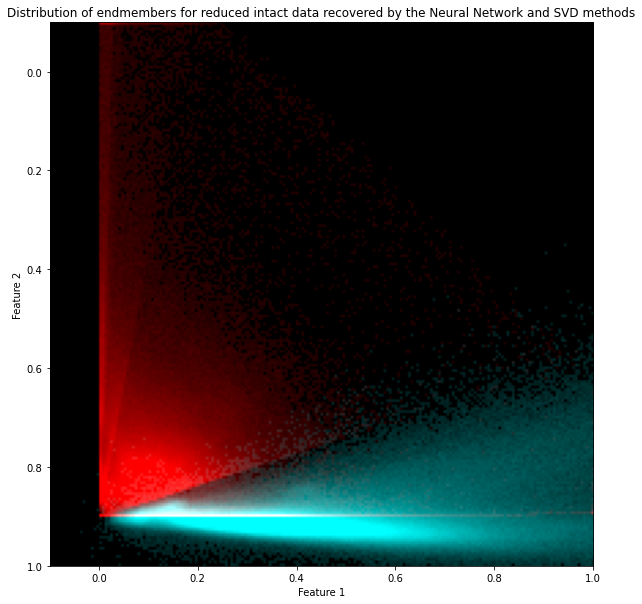

In [266]:
" For Reduced Intact data"
scale = 1000
H1 = hist_ri
H2 = hist_svd_ri
H1 = H1/scale
H2 = H2/scale

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of endmembers for reduced intact data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


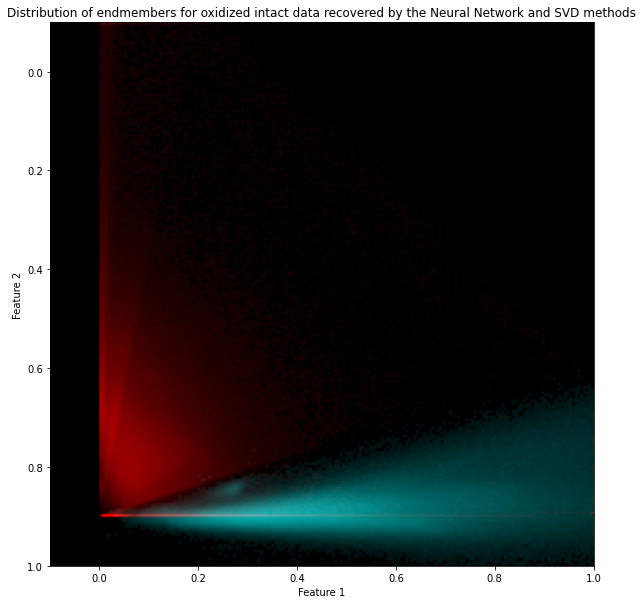

In [267]:
" For Reduced Intact data"
H1 = hist_oi
H2 = hist_svd_oi
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of endmembers for oxidized intact data recovered by the Neural Network and SVD methods')
plt.show()

### NN vs. SVD comparisons in terms of histogram distributions Feature 1 vs. Feature 3

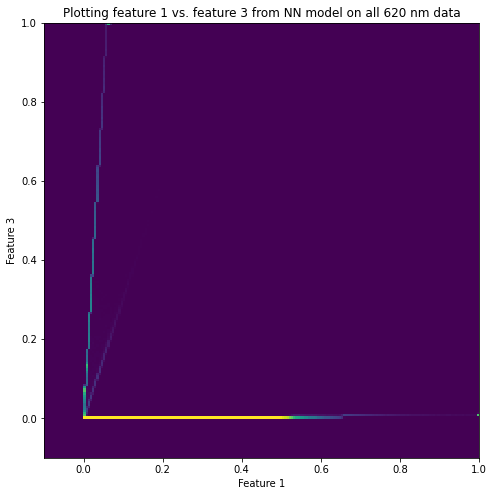

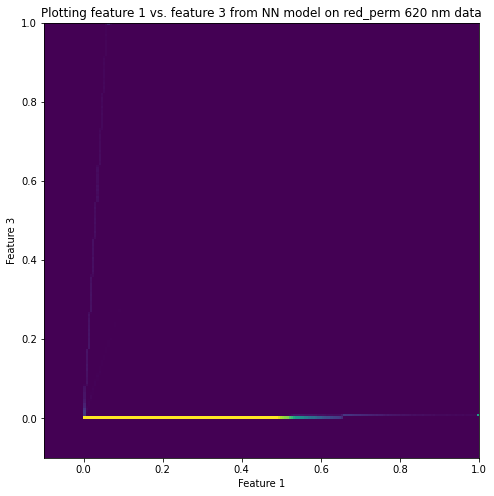

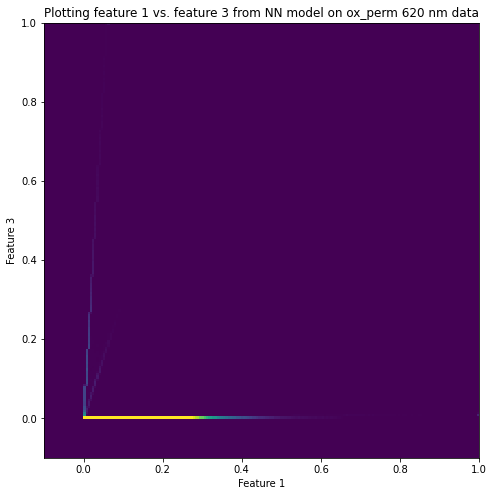

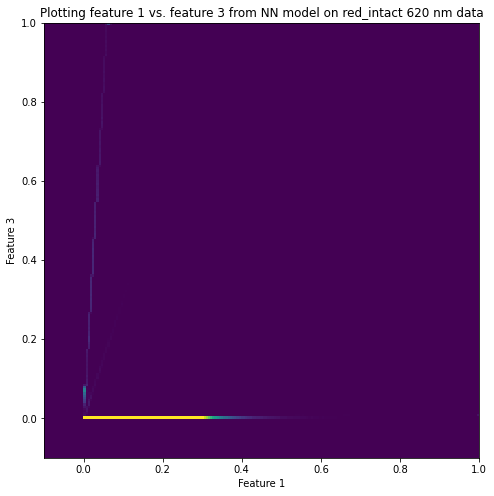

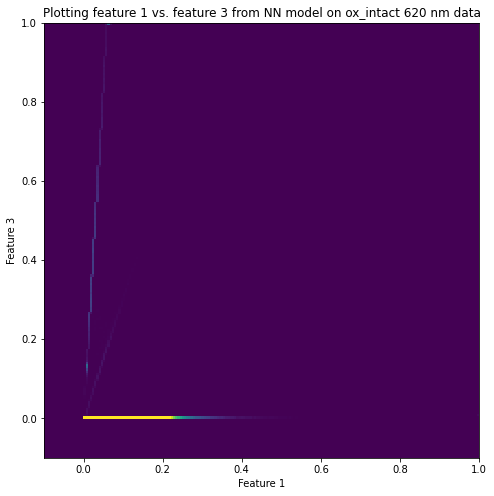

In [319]:

eps = 1e-7
ind1 = int(model.indices[0])
ind2 = int(model.indices[2])

# histogram for all predictions
x = preds_rolled[ind1,:]
y = preds_rolled[ind2,:]

xedges = np.linspace(-0.1, 1, 200)
yedges = np.linspace(-0.1, 1, 200)

hist, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist = hist.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from NN model on all 620 nm data')
plt.show()

# histogram for red_perm predictions
x = preds_rolled_rp[ind1,:]
y = preds_rolled_rp[ind2,:]


hist_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_rp = hist_rp.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_rp + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_rp, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from NN model on red_perm 620 nm data')
plt.show()

# histogram for ox perm predictions
x = preds_rolled_op[ind1,:]
y = preds_rolled_op[ind2,:]


hist_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_op = hist_op.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_op + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_op, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from NN model on ox_perm 620 nm data')
plt.show()

# histogram for reduced intact predictions
x = preds_rolled_ri[ind1,:]
y = preds_rolled_ri[ind2,:]

hist_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_ri = hist_ri.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_ri + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_ri, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from NN model on red_intact 620 nm data')
plt.show()


# histogram for oxidized intact predictions
x = preds_rolled_oi[ind1,:]
y = preds_rolled_oi[ind2,:]


hist_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_oi = hist_oi.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_oi + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_oi, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from NN model on ox_intact 620 nm data')
plt.show()

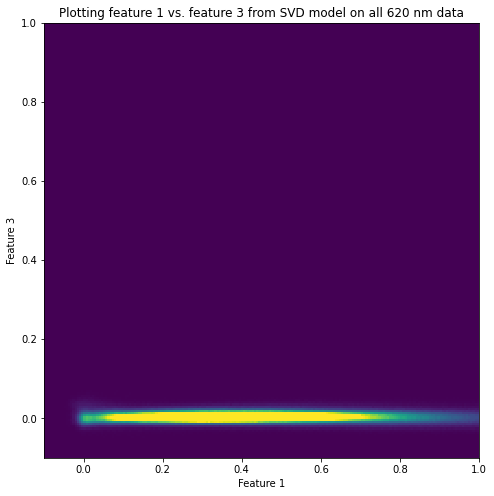

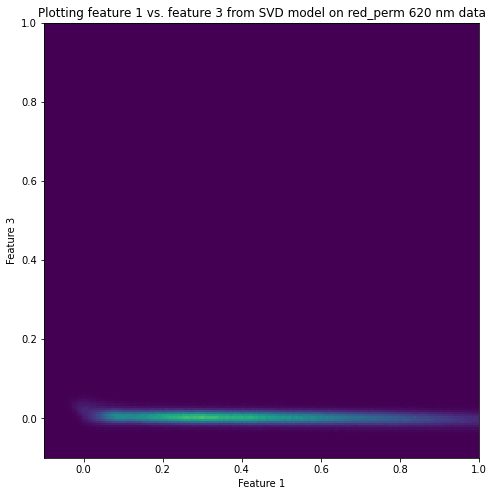

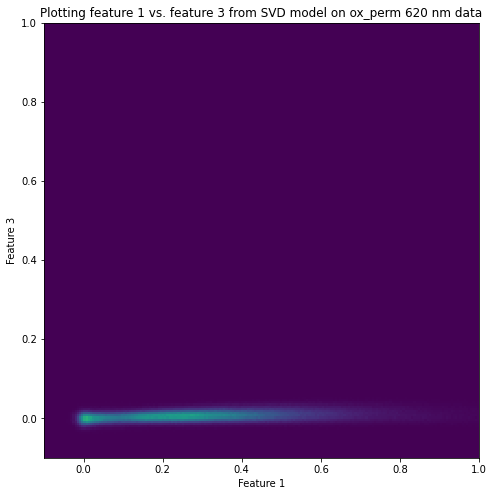

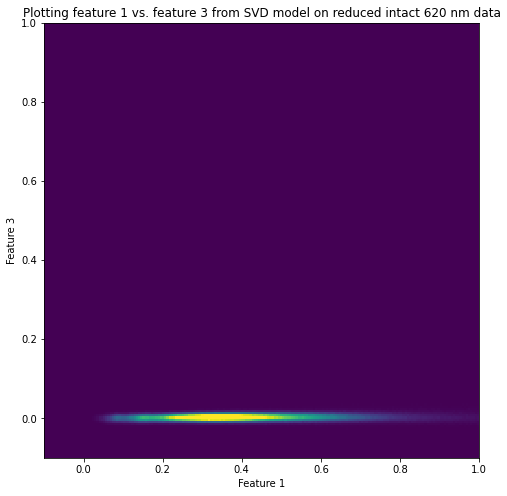

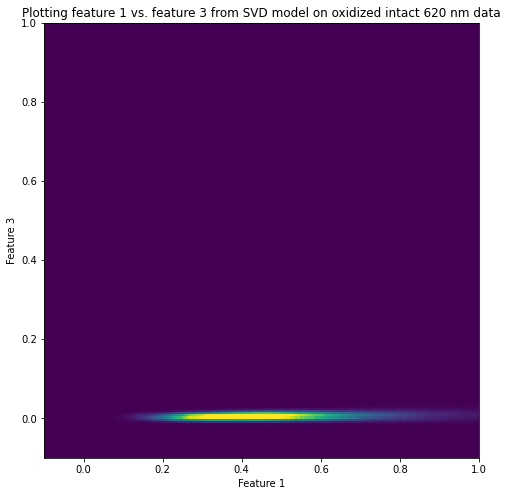

In [320]:
# plot 2D histogram of the SVD analysis

plot_ind1 = 0
plot_ind2 = 2

x = stack_svd[plot_ind1, :]
y = stack_svd[plot_ind2, :]

hist_svd, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd = hist_svd.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.imshow(hist_svd, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from SVD model on all 620 nm data')
plt.show()


x = stack_svd_rp[plot_ind1, :]
y = stack_svd_rp[plot_ind2, :]

hist_svd_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_rp = hist_svd_rp.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_rp + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_rp, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from SVD model on red_perm 620 nm data')
plt.show()


x = stack_svd_op[plot_ind1, :]
y = stack_svd_op[plot_ind2, :]

hist_svd_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_op = hist_svd_op.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_op + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_op, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from SVD model on ox_perm 620 nm data')
plt.show()


x = stack_svd_ri[plot_ind1, :]
y = stack_svd_ri[plot_ind2, :]

hist_svd_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_ri = hist_svd_ri.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_ri + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_ri, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from SVD model on reduced intact 620 nm data')
plt.show()


x = stack_svd_oi[plot_ind1, :]
y = stack_svd_oi[plot_ind2, :]

hist_svd_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_oi = hist_svd_oi.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_oi + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_oi, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Plotting feature 1 vs. feature 3 from SVD model on oxidized intact 620 nm data')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


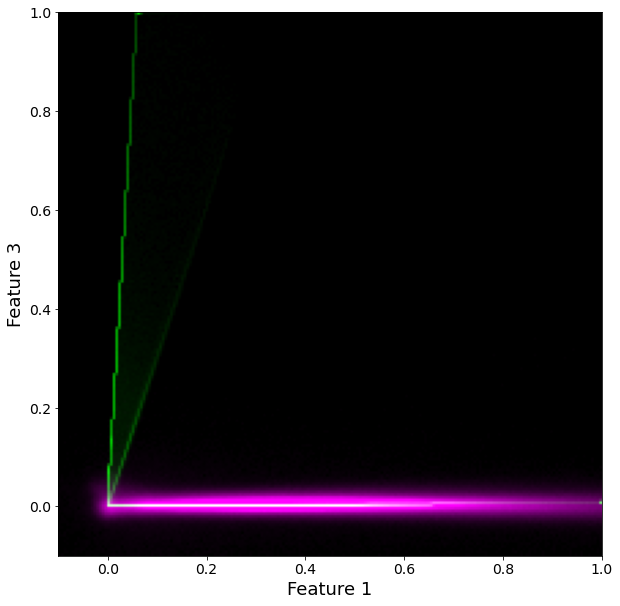

In [322]:
"For all data"
H1 = hist/norm
H2 = hist_svd/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H2
rgb[:,:,1] = H1
rgb[:,:,2] = H2

plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[-1], yedges[0]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1', fontsize = 18)
plt.ylabel('Feature 3', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.title('Distribution of endmembers for all data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


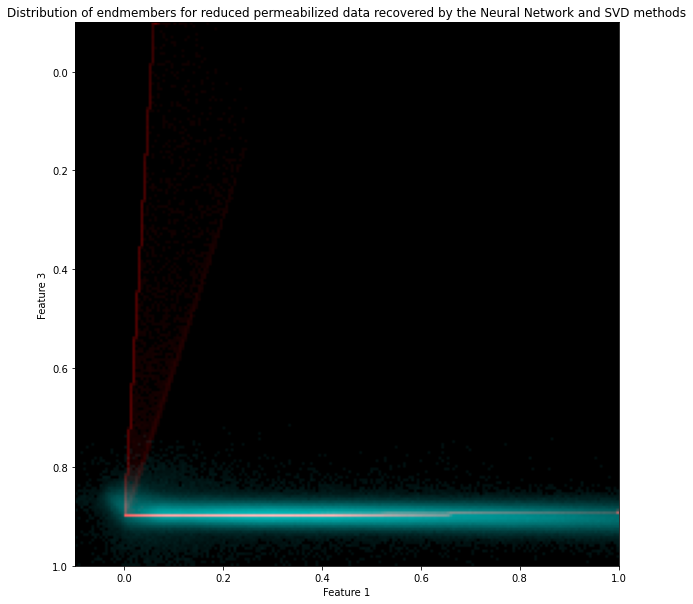

In [271]:
" For Reduced Permeabilized data"
H1 = hist_rp
H2 = hist_svd_rp
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H2
rgb[:,:,1] = H1
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for reduced permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


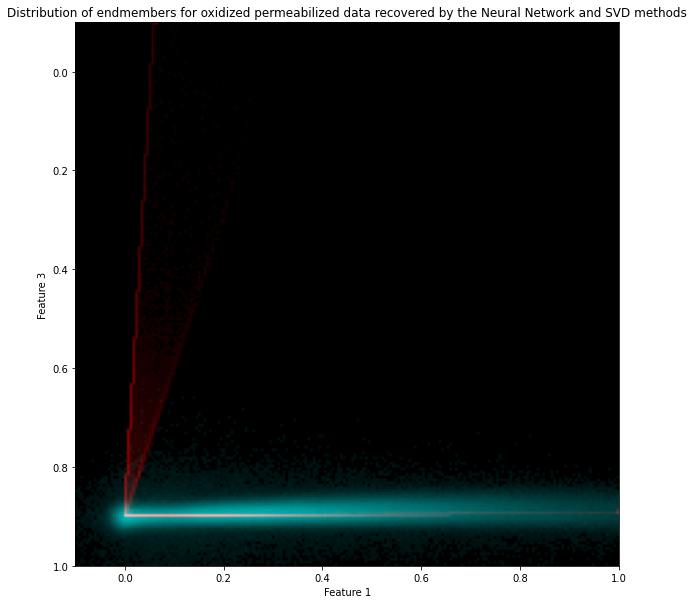

In [272]:
" For Oxidized Permeabilized data"
H1 = hist_op
H2 = hist_svd_op
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for oxidized permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


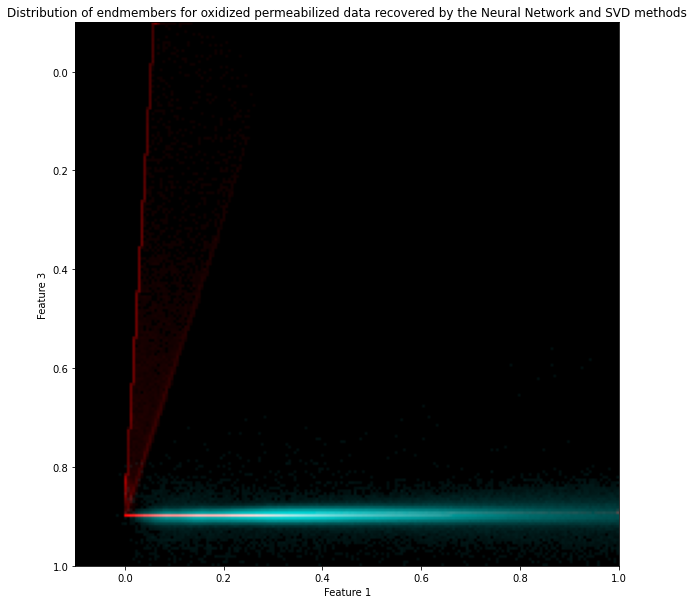

In [273]:
" For Reduced Intact data"
H1 = hist_ri
H2 = hist_svd_ri
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for oxidized permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


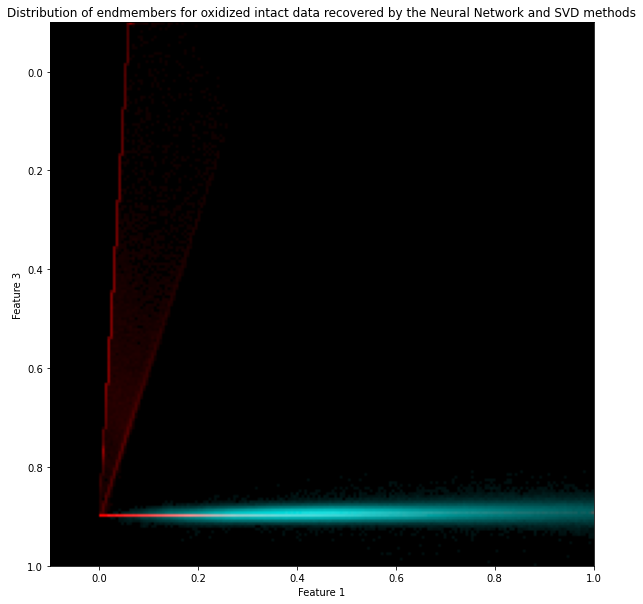

In [274]:
" For Oxidized Intact data"
H1 = hist_oi
H2 = hist_svd_oi
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for oxidized intact data recovered by the Neural Network and SVD methods')
plt.show()

### NN vs. SVD comparisons in terms of histogram distributions Feature 2 vs. Feature 3

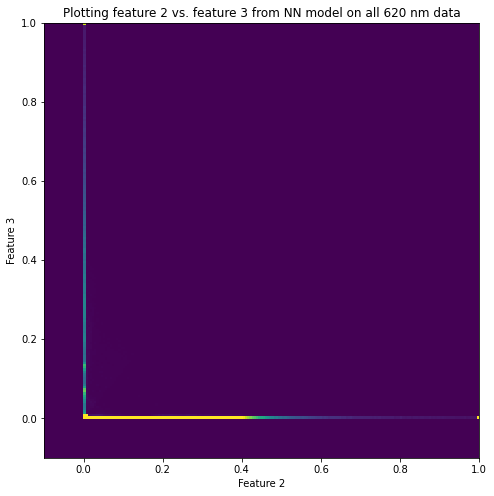

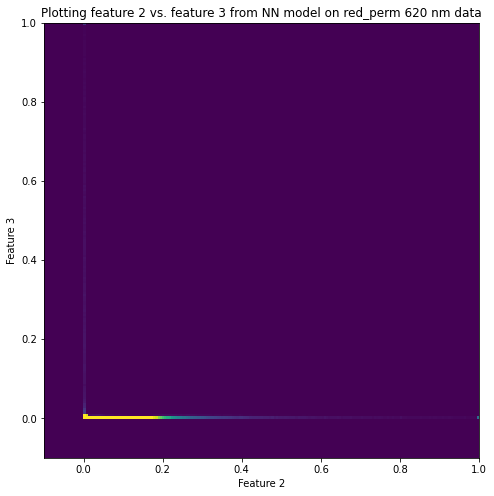

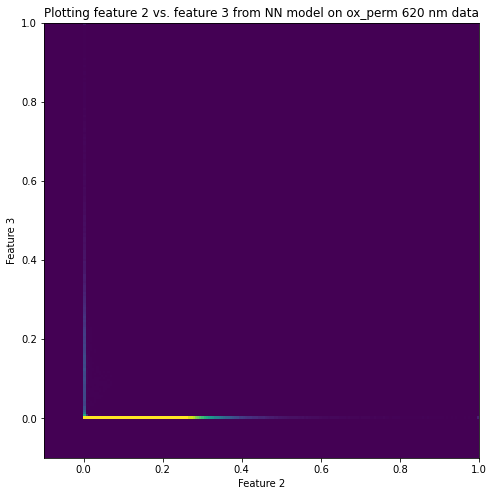

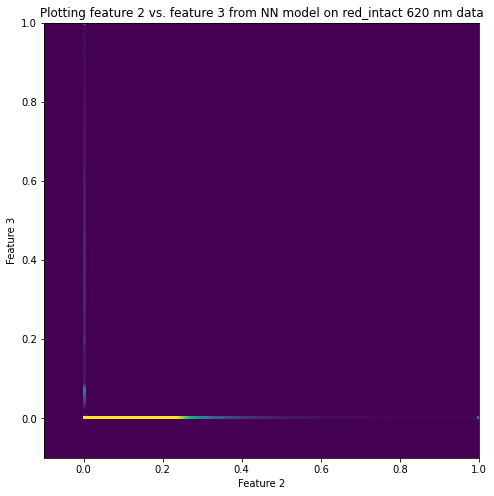

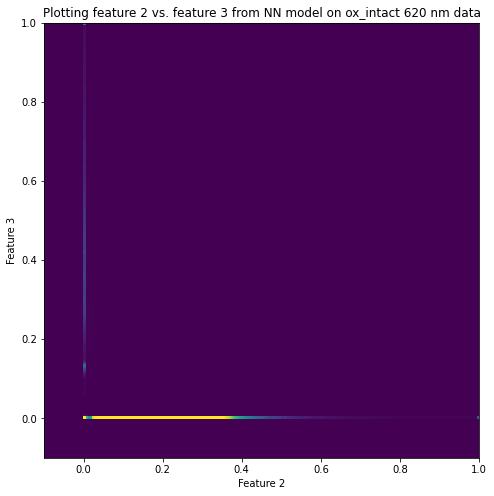

In [323]:
eps = 1e-7
ind1 = int(model.indices[1])
ind2 = int(model.indices[2])

# histogram for all predictions
x = preds_rolled[ind1,:]
y = preds_rolled[ind2,:]

xedges = np.linspace(-0.1, 1, 200)
yedges = np.linspace(-0.1, 1, 200)

hist, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist = hist.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from NN model on all 620 nm data')
plt.show()

# histogram for red_perm predictions
x = preds_rolled_rp[ind1,:]
y = preds_rolled_rp[ind2,:]


hist_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_rp = hist_rp.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_rp + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_rp, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from NN model on red_perm 620 nm data')
plt.show()

# histogram for ox perm predictions
x = preds_rolled_op[ind1,:]
y = preds_rolled_op[ind2,:]


hist_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_op = hist_op.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_op + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_op, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from NN model on ox_perm 620 nm data')
plt.show()

# histogram for reduced intact predictions
x = preds_rolled_ri[ind1,:]
y = preds_rolled_ri[ind2,:]

hist_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_ri = hist_ri.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_ri + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_ri, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from NN model on red_intact 620 nm data')
plt.show()


# histogram for oxidized intact predictions
x = preds_rolled_oi[ind1,:]
y = preds_rolled_oi[ind2,:]


hist_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_oi = hist_oi.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_oi + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_oi, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from NN model on ox_intact 620 nm data')
plt.show()

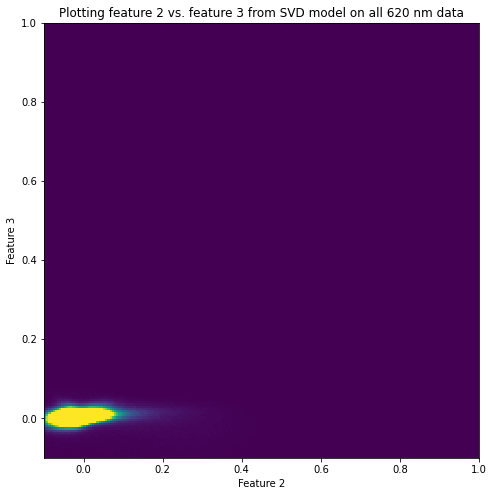

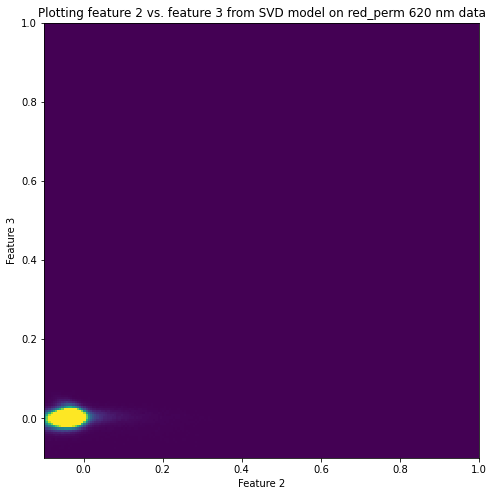

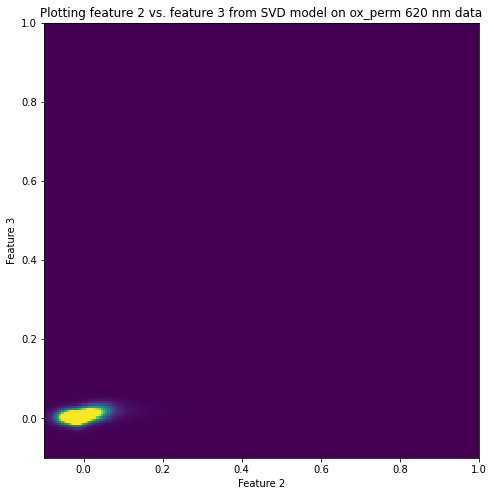

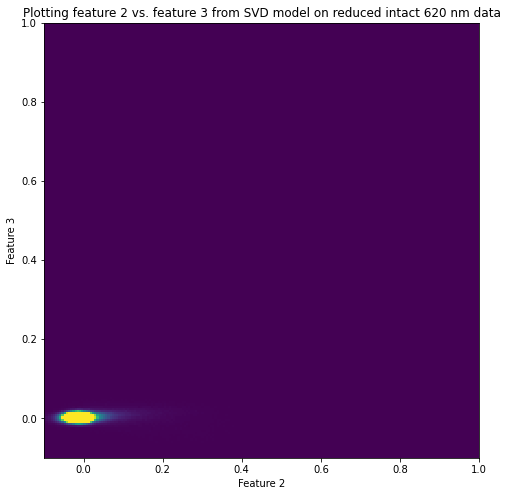

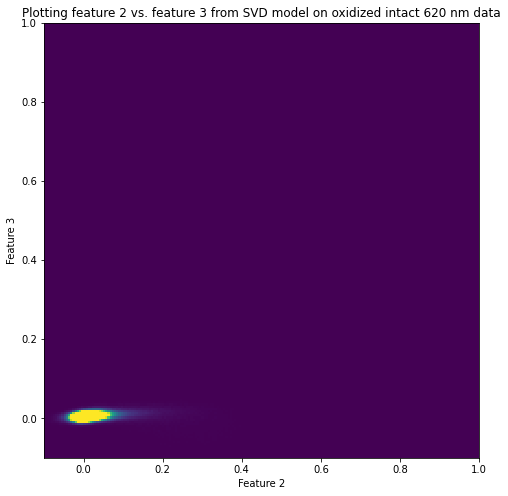

In [324]:
# plot 2D histogram of the SVD analysis

plot_ind1 = 1
plot_ind2 = 2

x = stack_svd[plot_ind1, :]
y = stack_svd[plot_ind2, :]

hist_svd, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd = hist_svd.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.imshow(hist_svd, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from SVD model on all 620 nm data')
plt.show()


x = stack_svd_rp[plot_ind1, :]
y = stack_svd_rp[plot_ind2, :]

hist_svd_rp, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_rp = hist_svd_rp.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_rp + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_rp, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from SVD model on red_perm 620 nm data')
plt.show()


x = stack_svd_op[plot_ind1, :]
y = stack_svd_op[plot_ind2, :]

hist_svd_op, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_op = hist_svd_op.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_op + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_op, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from SVD model on ox_perm 620 nm data')
plt.show()


x = stack_svd_ri[plot_ind1, :]
y = stack_svd_ri[plot_ind2, :]

hist_svd_ri, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_ri = hist_svd_ri.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_ri + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_ri, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from SVD model on reduced intact 620 nm data')
plt.show()


x = stack_svd_oi[plot_ind1, :]
y = stack_svd_oi[plot_ind2, :]

hist_svd_oi, xedges, yedges = np.histogram2d(x, y, bins = (xedges, yedges))
hist_svd_oi = hist_svd_oi.T

plt.figure(figsize=(8,8))
# plt.imshow(np.log(hist_svd_oi + eps), interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(hist_svd_oi, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin = 0, vmax = norm)

plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Plotting feature 2 vs. feature 3 from SVD model on oxidized intact 620 nm data')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


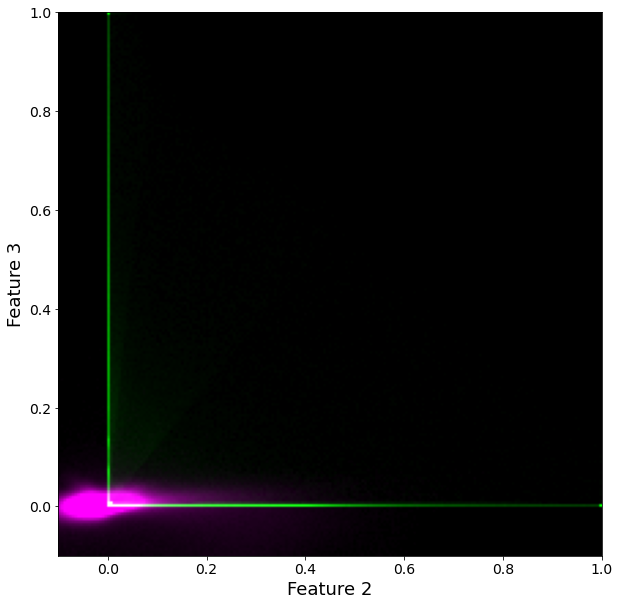

In [325]:
"For all data"
H1 = hist/norm
H2 = hist_svd/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H2
rgb[:,:,1] = H1
rgb[:,:,2] = H2

plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[-1], yedges[0]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 2', fontsize = 18)
plt.ylabel('Feature 3', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.title('Distribution of endmembers for all data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


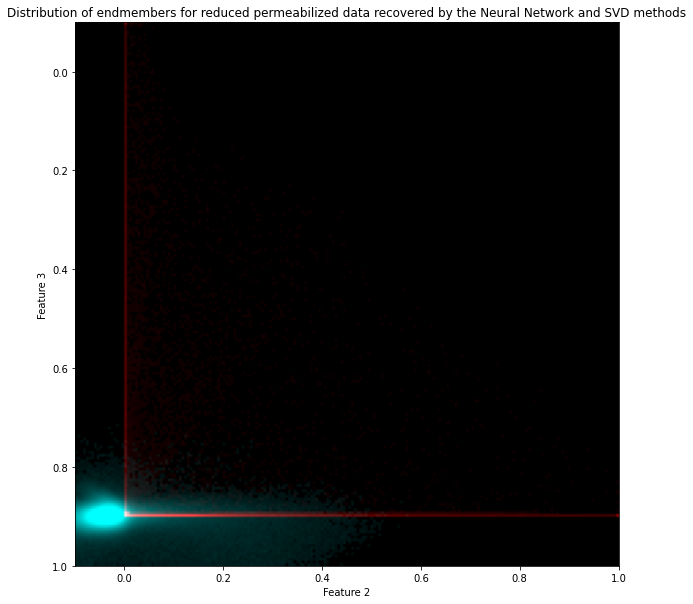

In [278]:
" For Reduced Permeabilized data"
H1 = hist_rp
H2 = hist_svd_rp
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for reduced permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


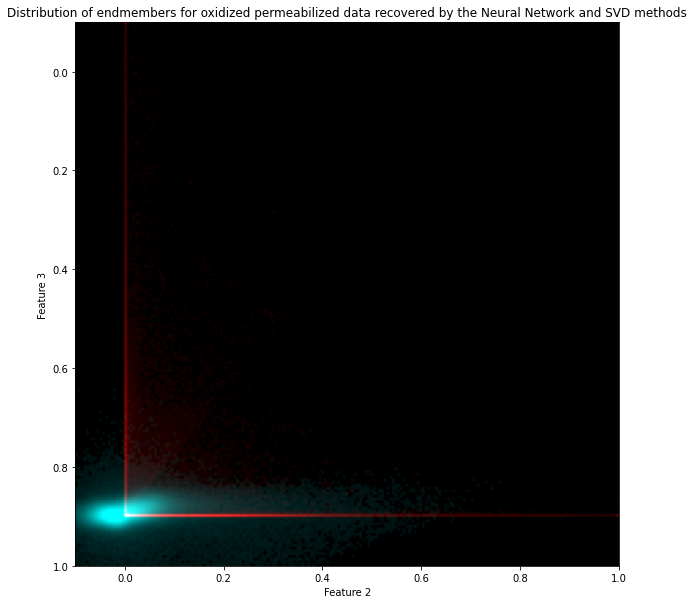

In [279]:
" For Oxidized Permeabilized data"
H1 = hist_op
H2 = hist_svd_op
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for oxidized permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


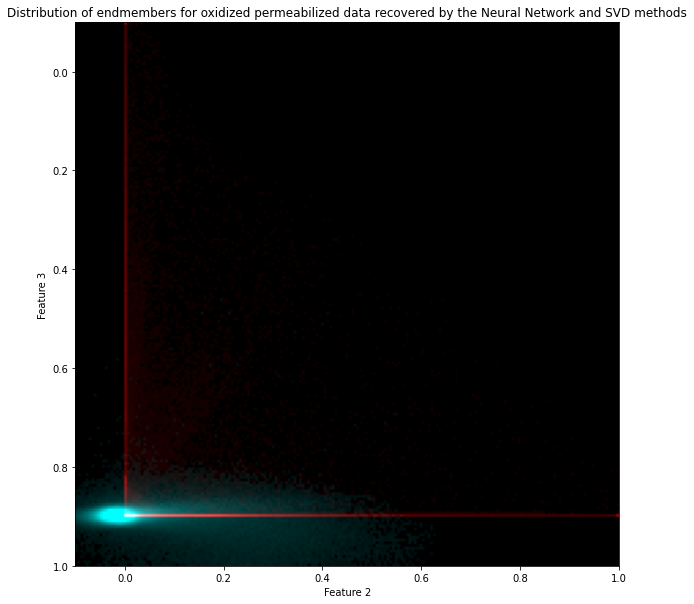

In [280]:
" For Reduced Intact data"
H1 = hist_ri
H2 = hist_svd_ri
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for oxidized permeabilized data recovered by the Neural Network and SVD methods')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


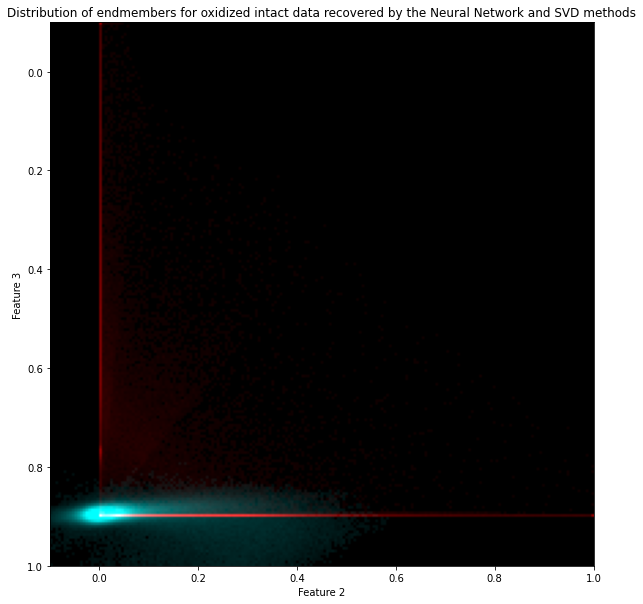

In [281]:
" For Oxidized Intact data"
H1 = hist_oi
H2 = hist_svd_oi
H1 = H1/norm
H2 = H2/norm

rgb = np.zeros((199,199,3))
rgb[:,:,0] = H1
rgb[:,:,1] = H2
rgb[:,:,2] = H2
plt.figure(figsize=(10,10))
plt.imshow(rgb**alpha, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().invert_yaxis()
plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('Distribution of endmembers for oxidized intact data recovered by the Neural Network and SVD methods')
plt.show()

## NN vs. SVD endmembers side by side

In [255]:
model.indices

array([1., 0., 2.])

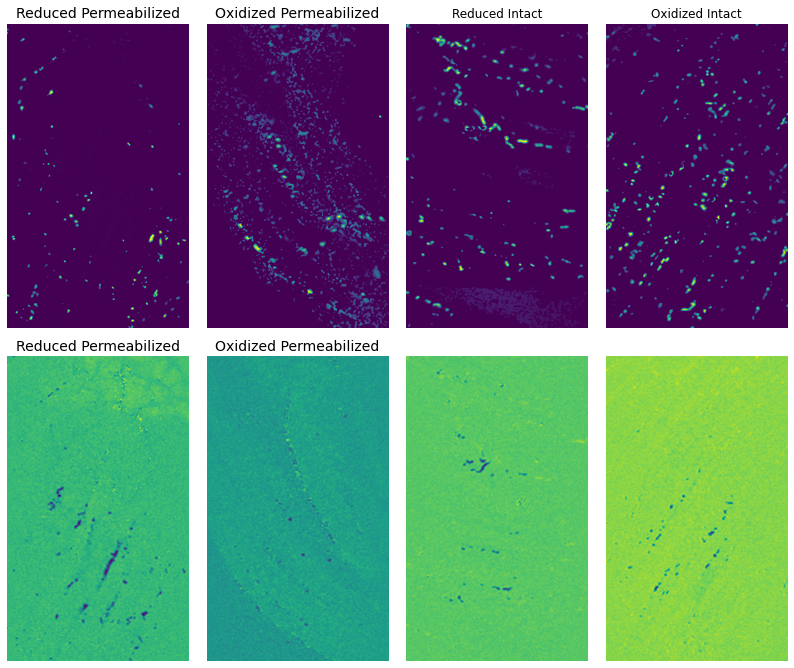

In [331]:
# creating grid for subplots
plot_ind = 2
model_ind = int(model.indices[plot_ind])
fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)
 
ax1 = plt.subplot2grid(shape=(3, 5), loc=(0, 0), rowspan=1)
ax2 = plt.subplot2grid(shape=(3, 5), loc=(0, 1), rowspan=1)
ax3 = plt.subplot2grid(shape=(3, 5), loc=(0, 2), rowspan=1)
ax4 = plt.subplot2grid(shape=(3, 5), loc=(0, 3), rowspan=1)
ax5 = plt.subplot2grid(shape=(3, 5), loc=(1, 0), rowspan=1)
ax6 = plt.subplot2grid(shape=(3, 5), loc=(1, 1), rowspan=1)
ax7 = plt.subplot2grid(shape=(3, 5), loc=(1, 2), rowspan=1)
ax8 = plt.subplot2grid(shape=(3, 5), loc=(1, 3), rowspan=1)
 
# plotting subplots

ax1.imshow(preds[model_ind,:,:,0])
ax1.set_title('Reduced Permeabilized', fontsize = 14)
ax1.set_axis_off()

ax2.imshow(preds[model_ind,:,:,1])
ax2.set_axis_off()
ax2.set_title('Oxidized Permeabilized', fontsize = 14)

ax3.imshow(preds[model_ind,:,:,4])
ax3.set_axis_off()
ax3.set_title('Reduced Intact')

ax4.imshow(preds[model_ind,:,:,5])
ax4.set_axis_off()
ax4.set_title('Oxidized Intact')

ax5.imshow(stack_svd_reshaped[0,:,:,plot_ind])
ax5.set_title('Reduced Permeabilized', fontsize = 14)
ax5.set_axis_off()

ax6.imshow(stack_svd_reshaped[1,:,:,plot_ind])
ax6.set_title('Oxidized Permeabilized', fontsize = 14)
ax6.set_axis_off()

ax7.imshow(stack_svd_reshaped[4,:,:,plot_ind])
ax7.set_axis_off()

ax8.imshow(stack_svd_reshaped[5,:,:,plot_ind])
ax8.set_axis_off()

 
# automatically adjust padding horizontally
# as well as vertically.
plt.tight_layout()
 
# display plot
plt.show()